##🚀drive mounting

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1gnEmwyGy0LbTbJbAObG1GluWXj6wpHMD/[2024-2025] AN2DL/Homework 2


##📚importing libraries

In [ ]:
# Set seed for reproducibility
seed = 42


# Import necessary libraries

import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


##📊Dataset

In previous explorations of the dataset we found some outliers and we decided to definitively remove them from out dataset

In [ ]:
import numpy as np

data = np.load("filtered_mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
import gc
del data, training_set
gc.collect()

26

###visual inspection

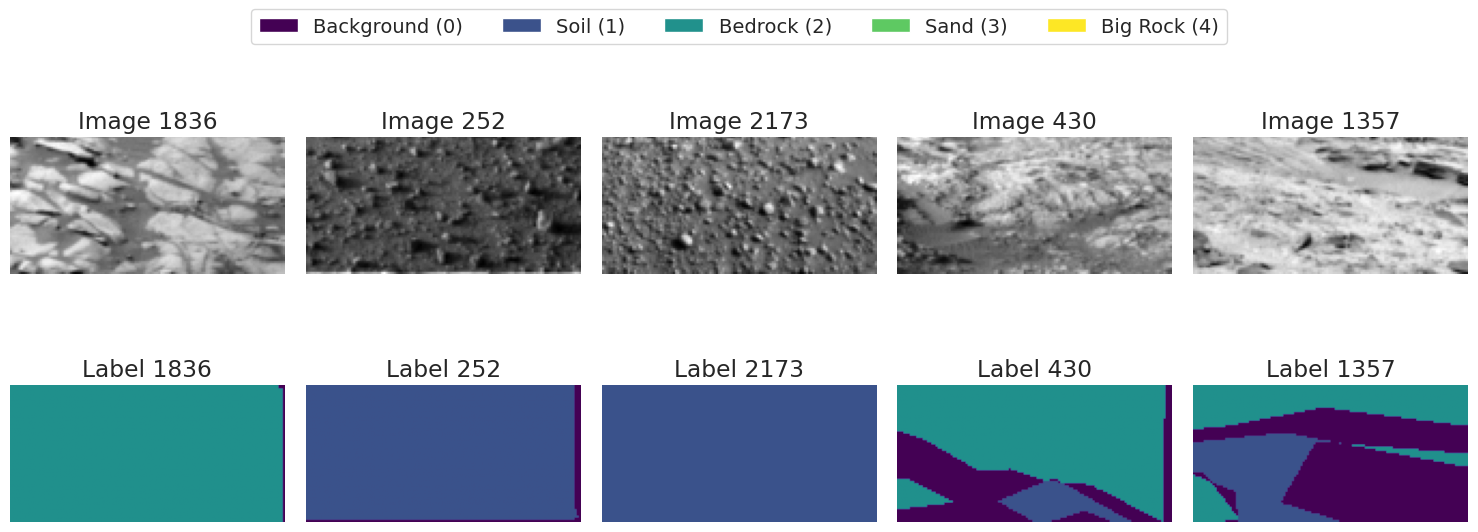

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Function to plot random images with labels
def plot_random_images_with_labels(images, labels, num=5):
    """
    Plot `num` random images with their corresponding label masks.

    Parameters:
        images (numpy.ndarray): Array of images.
        labels (numpy.ndarray): Array of label masks.
        num (int): Number of images to plot.
    """
    # Select `num` random indices
    random_indices = np.random.choice(len(images), num, replace=False)

    fig, axes = plt.subplots(2, num, figsize=(num * 3, 6))  # More compact figure

    for i, idx in enumerate(random_indices):
        # Display the image
        axes[0, i].imshow(images[idx], cmap='gray')
        axes[0, i].set_title(f"Image {idx}")
        axes[0, i].axis("off")

        # Display the mask with viridis
        axes[1, i].imshow(labels[idx], cmap='viridis', vmin=0, vmax=4)
        axes[1, i].set_title(f"Label {idx}")
        axes[1, i].axis("off")

    # Add a legend for the classes above the figure
    legend_elements = [
        Patch(facecolor=plt.cm.viridis(0 / 4), label='Background (0)'),
        Patch(facecolor=plt.cm.viridis(1 / 4), label='Soil (1)'),
        Patch(facecolor=plt.cm.viridis(2 / 4), label='Bedrock (2)'),
        Patch(facecolor=plt.cm.viridis(3 / 4), label='Sand (3)'),
        Patch(facecolor=plt.cm.viridis(4 / 4), label='Big Rock (4)')
    ]
    fig.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=5,
        fontsize='medium'
    )

    plt.tight_layout()
    plt.show()

# Plot 5 random images with labels
plot_random_images_with_labels(X_train, y_train, num=5)


###data processing

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Distribuzione delle classi: {0.0: 4988826, 1.0: 6957538, 2.0: 4776810, 3.0: 3770823, 4.0: 26963}


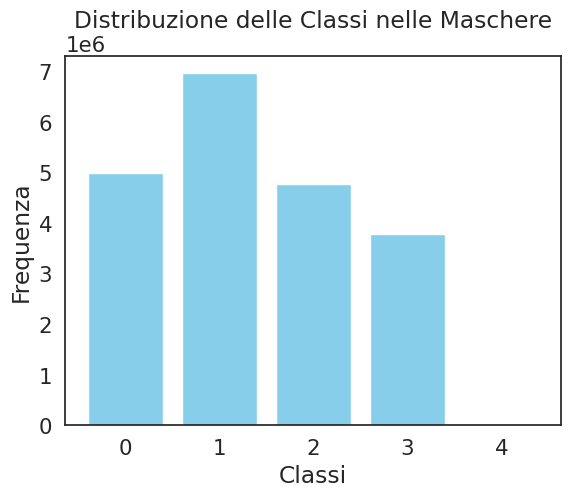

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar chart
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")


In [ ]:
from sklearn.model_selection import train_test_split

# First split: divide into train and temp (which will become validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Second split: divide into validation and test
X_val, X_test_tmp, y_val, y_test_tmp = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the size of the new splits
print(f"Number of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test_tmp)}")


Number of images:
Train: 2004
Validation: 250
Test: 251


Distribuzione delle classi: {0.0: 3979893, 1.0: 5532162, 2.0: 3924593, 3.0: 2958791, 4.0: 21329}


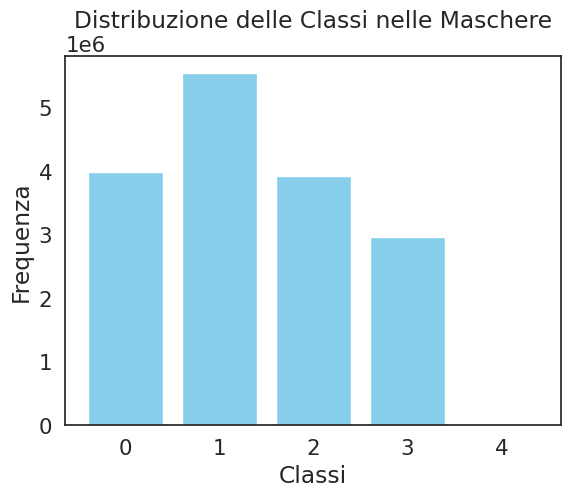

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar chart
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")

It is clear that there are classes that are highly represented, while others are significantly less represented

###preparing the dataset

We prepare the training dataset (applying geometric augmentation such as random flipping), the validation dataset, and the test dataset. Additionally, we set essential parameters such as batch size, patience, number of epochs, and learning rate

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """
    Random horizontal flip for image and its corresponding segmentation mask (label).
    Visualizes three images with masks before and after the flip.

    Args:
        image: Tensor representing the image, size [H, W, C].
        label: Tensor representing the segmented mask, size [H, W] or [H, W, 1].
        seed: Optional seed for the random generator.

    Returns:
        Flipped (or unchanged) image and label.
    """
    # Generate a random seed if not provided
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure that the label has 3 dimensions
    if len(label.shape) == 2:  # Adds a channel dimension
        label = tf.expand_dims(label, axis=-1)

    # Save copies of the original images and masks for visualization
    original_image = image.numpy() if tf.executing_eagerly() else image
    original_label = label.numpy() if tf.executing_eagerly() else label

    # Random uniform to determine the flip
    flip_prob = tf.random.uniform([], seed=seed)

    # Apply conditional horizontal flip
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    return image, label


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

In [ ]:
import numpy as np

# Add the channel to X_train and X_test
X_train = np.expand_dims(X_train, axis=-1)  # Add a channel
X_test_tmp = np.expand_dims(X_test_tmp, axis=-1)  # Add a channel
X_val = np.expand_dims(X_val, axis=-1)

input_shape = X_train.shape[1:]  # The input shape (without batch dimension)
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")


Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
import tensorflow as tf

def make_dataset(X_train, y_train, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset from X_train and y_train.

    Parameters:
    - X_train: Training images.
    - y_train: Training labels.
    - batch_size: Number of elements per batch.
    - shuffle: If True, shuffle the dataset.
    - augment: If True, apply augmentations to the images.
    - seed: Seed for randomness (optional).

    Returns:
    - dataset: TensorFlow dataset.
    """

    # Add the fourth dimension to y_train if necessary
    if len(y_train.shape) == 3:  # If y_train is shaped (n_samples, height, width)
        y_train = tf.expand_dims(y_train, axis=-1)  # Convert to (n_samples, height, width, 1)

    # Create a dataset from X_train and y_train
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Apply shuffle
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size, seed=seed)

    # Apply augmentations
    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Perform batching
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Optimize data loading
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    X_test_tmp, y_test_tmp,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


Visualizing examples from the training set:


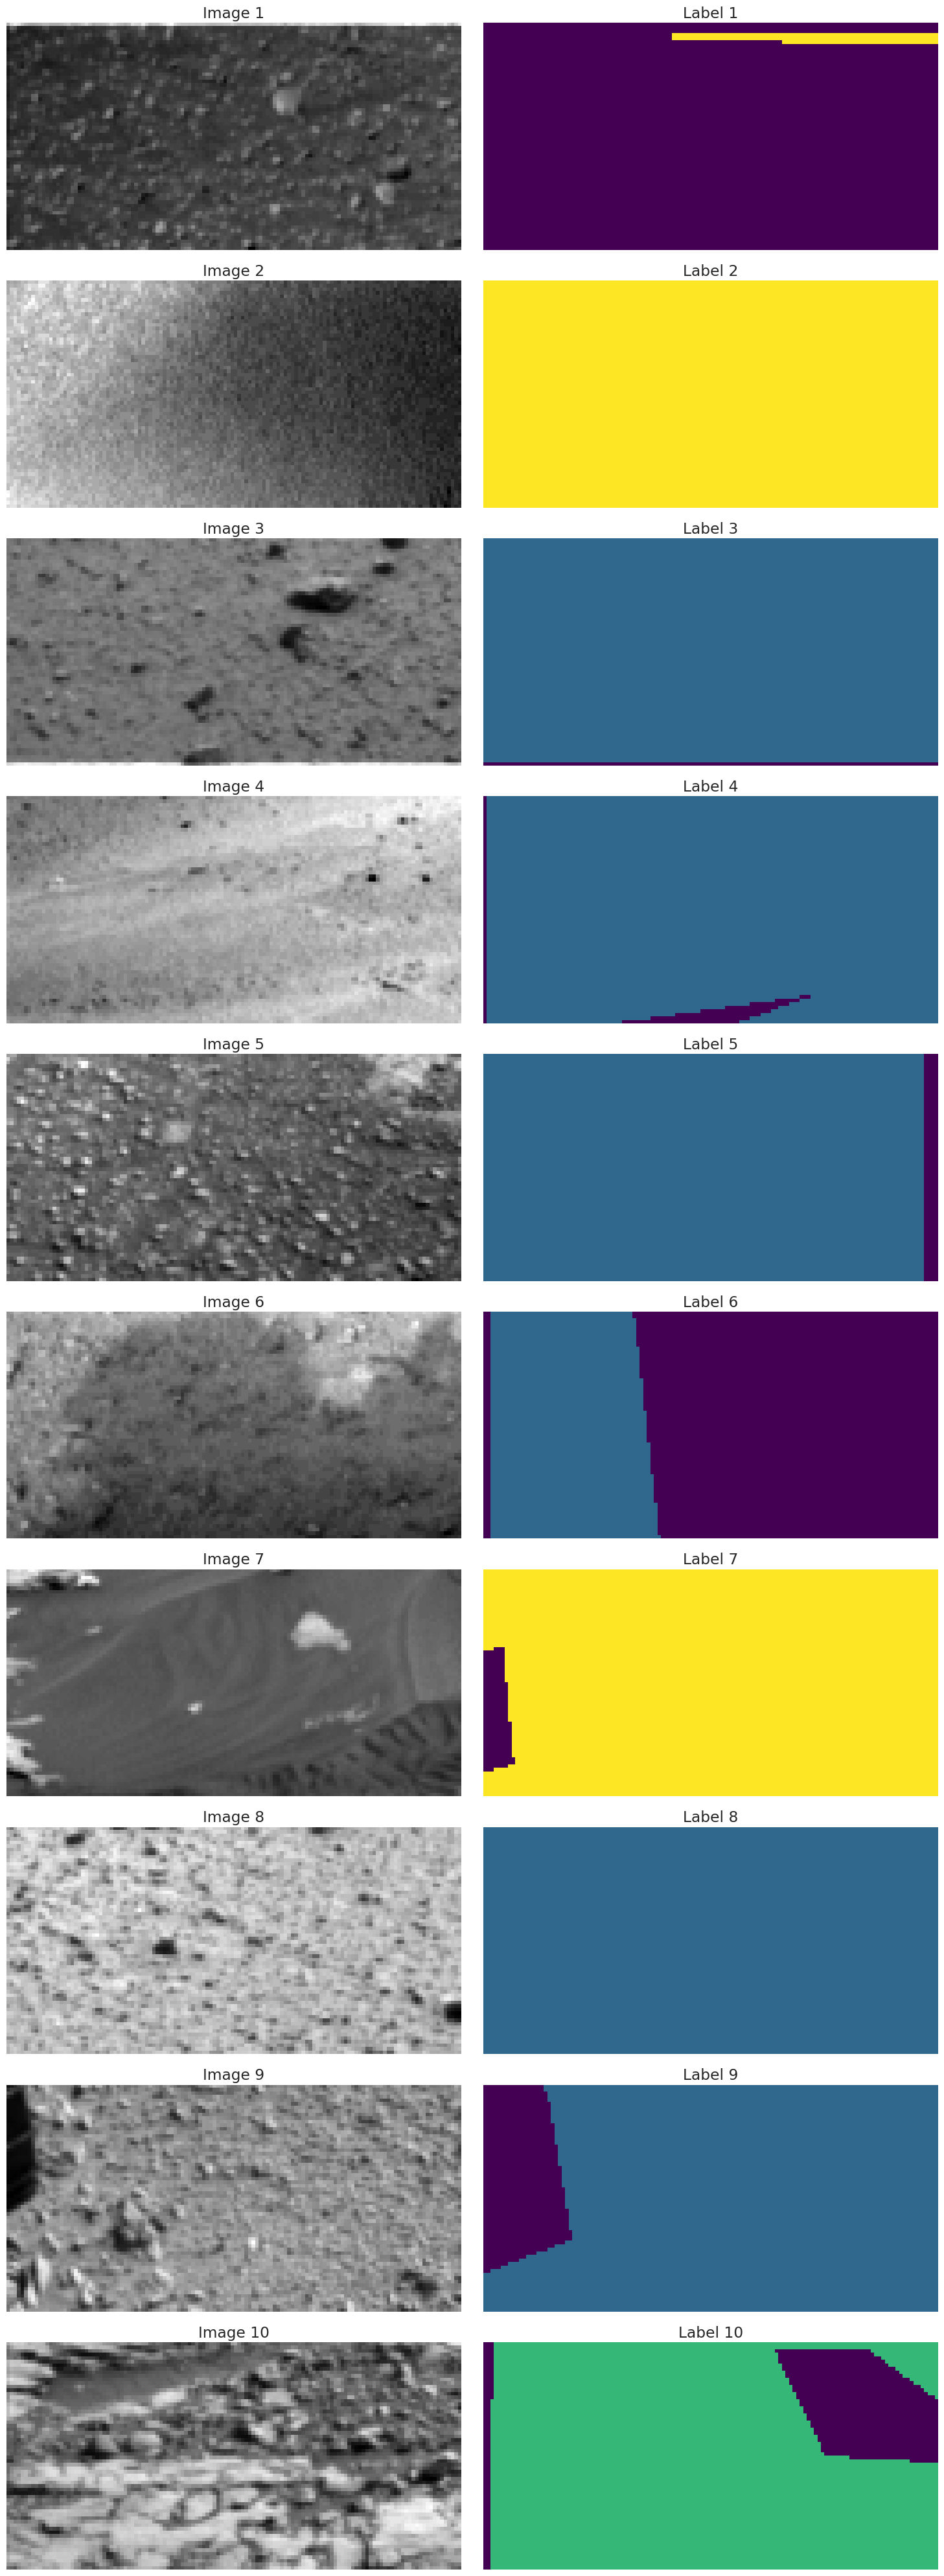

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(tf.squeeze(images[j], axis=-1)*255, cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=10)

Above are examples of the training dataset created

##💡Model

We define a U-Net model with 3 downsampling layers and 3 upsampling layers (using a basic U-block). In each upsampling layer, we add an attention block. In the bottleneck, we implement an improved ASPP layer

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x


def improved_aspp_block(input_tensor, filters=128, dropout_rate=0.3):
    """
    Improved Atrous Spatial Pyramid Pooling (ASPP) Block with added normalization,
    adaptive filters, and multi-level regularization.
    """
    # 1x1 Convolution
    conv_1x1 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(input_tensor)
    conv_1x1 = tfkl.BatchNormalization()(conv_1x1)

    # Dilated convolutions
    conv_3x3_1 = tfkl.Conv2D(filters, (3, 3), dilation_rate=6, padding="same", activation="relu")(input_tensor)
    conv_3x3_1 = tfkl.BatchNormalization()(conv_3x3_1)

    conv_3x3_2 = tfkl.Conv2D(filters, (3, 3), dilation_rate=12, padding="same", activation="relu")(input_tensor)
    conv_3x3_2 = tfkl.BatchNormalization()(conv_3x3_2)

    conv_3x3_3 = tfkl.Conv2D(filters, (3, 3), dilation_rate=18, padding="same", activation="relu")(input_tensor)
    conv_3x3_3 = tfkl.BatchNormalization()(conv_3x3_3)

    # Global Average Pooling
    gap = tfkl.GlobalAveragePooling2D()(input_tensor)
    gap = tfkl.Reshape((1, 1, input_tensor.shape[-1]))(gap)
    gap = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(gap)
    gap = tfkl.BatchNormalization()(gap)
    gap = tfkl.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]))(gap)

    # Concatenate all branches
    x = tfkl.Concatenate()([conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3, gap])

    # Final 1x1 Convolution to combine features
    x = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)

    # Add multiple levels of Dropout
    x = tfkl.Dropout(dropout_rate)(x)  # Standard Dropout
    x = tfkl.SpatialDropout2D(dropout_rate)(x)  # Spatial Dropout

    return x



def attention_block(x, g, inter_channel):
    """
    Attention Gate: Modulates features in skip connections using gating signals.
    Args:
        x: Feature map from the encoder (skip connection input).
        g: Gating signal from the decoder.
        inter_channel: Number of filters for intermediate computations.
    Returns:
        Modified feature map with attention applied.
    """
    theta_x = tfkl.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = tfkl.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)

    add_xg = tfkl.Add()([theta_x, phi_g])
    act_xg = tfkl.Activation('relu')(add_xg)
    psi = tfkl.Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act_xg)
    sigmoid_psi = tfkl.Activation('sigmoid')(psi)

    return tfkl.Multiply()([x, sigmoid_psi])

def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    """U-Net Model with 3 Downsampling and 3 Upsampling Blocks using Add instead of Concatenate"""
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck with ASPP
    # Bottleneck
    bottleneck = improved_aspp_block(d3, filters=256, dropout_rate=0.4)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    #u1 = tfkl.Conv2D(128, kernel_size=1, padding='same', name='adjust_u1_channels')(u1)  # Match channels
    #u1 = tfkl.Add()([u1, down_block_3])
    a1= attention_block(down_block_3, u1, 128)
    u1 = tfkl.Concatenate()([u1, a1])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    #u2 = tfkl.Conv2D(64, kernel_size=1, padding='same', name='adjust_u2_channels')(u2)  # Match channels
    #u2 = tfkl.Add()([u2, down_block_2])
    a2= attention_block(down_block_2, u2, 64)
    u2 = tfkl.Concatenate()([u2, a2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    #u3 = tfkl.Conv2D(32, kernel_size=1, padding='same', name='adjust_u3_channels')(u3)  # Match channels
    #u3 = tfkl.Add()([u3, down_block_1])
    a3= attention_block(down_block_1, u3, 32)
    u3 = tfkl.Concatenate()([u3, a3])
    u3 = unet_block(u3, 32, name='up_block3_')

    # Add Spatial Dropout in the Decoder Path
    u3 = tfkl.SpatialDropout2D(rate=0.4)(u3)

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
# Model creation
model = get_unet_model()
model.summary()


# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv1         │ (None, 64, 128, 32)    │            320 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn1           │ (None, 64, 128, 32)    │            128 │ down_block1_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation1   │ (None, 64, 128, 32)    │              0 │ down_block1_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv2         │ (None, 64, 128, 32)    │          9,248 │ down_block1_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn2           │ (None, 64, 128, 32)    │            128 │ down_block1_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation2   │ (None, 64, 128, 32)    │              0 │ down_block1_bn2[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 32)     │              0 │ down_block1_activatio… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_conv1         │ (None, 32, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_bn1           │ (None, 32, 64, 64)     │            256 │ down_block2_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_activation1   │ (None, 32, 64, 64)     │              0 │ down_block2_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_conv2         │ (None, 32, 64, 64)     │         36,928 │ down_block2_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_bn2           │ (None, 32, 64, 64)     │            256 │ down_block2_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_activatio

 Total params: 2,415,592 (9.21 MB)

 Trainable params: 2,410,728 (9.20 MB)

 Non-trainable params: 4,864 (19.00 KB)

Above, you can see the structure of the created model and the number of parameters

We define the MIoU (Mean Intersection over Union) and the Viz Callback to monitor the model's performance during training. MIoU is used as a metric to evaluate the accuracy of pixel-wise segmentation, while the Viz Callback helps visualize the model's predictions in real-time, providing insights into the training process.

In [ ]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


In [ ]:
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, sample_images, sample_labels, frequency=5):
        """
        Visualization callback to monitor predictions during training.

        Args:
        - sample_images: A list of two NumPy arrays, each representing an image.
        - sample_labels: A list of two NumPy arrays, each representing a segmentation mask.
        - frequency: Frequency in terms of epochs to display the results.
        """
        super().__init__()
        self.sample_images = sample_images  # List of two images
        self.sample_labels = sample_labels  # List of two masks
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        """
        Displays the predictions at the end of every `frequency` epochs.
        """
        if epoch % self.frequency == 0:
            num_samples = len(self.sample_images)

            # Create the colormap
            num_classes = self.model.output_shape[-1]  # Number of classes from the model
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4 * num_samples))  # Expands vertical size for more images

            for i in range(num_samples):
                image = tf.expand_dims(self.sample_images[i], 0)  # Adds batch dimension
                label = self.sample_labels[i]  # Associated label

                # Generate prediction
                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()[0]  # Removes batch dimension

                # Input image
                plt.subplot(num_samples, 3, i * 3 + 1)
                plt.imshow(tf.squeeze(self.sample_images[i]), cmap='gray')
                plt.title(f"Input Image {i + 1}")
                plt.axis('off')

                # Ground truth
                plt.subplot(num_samples, 3, i * 3 + 2)
                colored_label = apply_colormap(label, colormap)
                plt.imshow(colored_label)
                plt.title(f"Ground Truth Mask {i + 1}")
                plt.axis('off')

                # Prediction
                plt.subplot(num_samples, 3, i * 3 + 3)
                colored_pred = apply_colormap(y_pred, colormap)
                plt.imshow(colored_pred)
                plt.title(f"Predicted Mask {i + 1}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


sample_images = [X_val[0], X_val[1]]
sample_labels = [y_val[0], y_val[1]]
viz_callback = VizCallback(sample_images, sample_labels, frequency=5)


In [ ]:

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

We compute class weights to address class imbalance and normalize them into alpha. This alpha is then used in the custom Sparse Categorical Focal Loss function, which emphasizes harder examples during training. The custom loss function adjusts the impact of each class and focuses on improving model performance on difficult-to-classify samples

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np # Import numpy

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1, 2, 3, 4]),  # Convert the list to a NumPy array
    y=y_train.flatten(),  # y_train deve essere in formato 1D
)
alpha = class_weights / sum(class_weights)
print(alpha)

[0.00524455 0.00377298 0.00531845 0.00705449 0.97860952]


In [ ]:
class SparseCategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=None, name="sparse_categorical_focal_loss"):
        """
        Implements the Focal Loss for integer labels.

        Parameters:
        - gamma: Modulates the balance between easy and hard examples.
        - alpha: Balances the contribution of classes (e.g., for class imbalance).
        """
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha  # Store alpha as an attribute, but don't calculate it here

    def call(self, y_true, y_pred):
        # Calculate alpha inside the call method if it's not provided
        if self.alpha is None:
            classes, counts = np.unique(y_train, return_counts=True)
            class_weights = compute_class_weight(
                class_weight="balanced",
                classes=np.array([0, 1, 2, 3, 4]),
                y=y_train.flatten()
            )
            alpha = class_weights / sum(class_weights)
        else:
            alpha = self.alpha  # Use the provided alpha if available

        alpha = tf.cast(alpha, tf.float32)  # Cast alpha to tf.float32

        # Convert predicted probabilities to log probabilities
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)

        # Calculate the probability of the true class
        one_hot_y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])
        true_prob = tf.reduce_sum(y_pred * one_hot_y_true, axis=-1)

        # Apply Focal Loss
        weight = tf.pow(1.0 - true_prob, self.gamma)  # Focus on hard examples

        # Reshape alpha to match the shape of weight
        alpha_reshaped = tf.gather(alpha, tf.cast(y_true[..., 0], tf.int32))  # Gather alpha values for true classes
        # alpha_reshaped = tf.reshape(self.alpha, [1, 1, -1]) # Reshape alpha to (1, 1, num_classes)
        # alpha_reshaped = tf.broadcast_to(alpha_reshaped, tf.shape(y_pred)) # Broadcast to match y_pred

        focal_loss = -alpha_reshaped * weight * tf.math.log(true_prob)

        return tf.reduce_mean(focal_loss)

    # Updated get_config method
    def get_config(self):
        """
        Returns the configuration of the loss function.
        """
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha.tolist() if self.alpha is not None else None  # Ensure serializable type
        })
        return config

    @classmethod
    def from_config(cls, config):
        """
        Creates a loss instance from the configuration.
        """
        return cls(**config)


We define a cosine decay learning rate schedule with a warmup phase, starting at 1e-4 and decaying to 1e-6 over time

In [ ]:
# Compile the model

import keras
reduce_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=120*32,
    alpha=1e-6,
    name="CosineDecay",
    warmup_target=1e-3,
    warmup_steps=120*32*0.1,
)
'''
reduce_lr=keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=120*32,
    decay_rate=0.96,
    staircase=False,
    name="ExponentialDecay",
)
'''

print("Compiling model...")
model.compile(
    loss=SparseCategoricalFocalLoss,
    optimizer = tf.keras.optimizers.AdamW(
    learning_rate=reduce_lr,
    weight_decay=1e-4),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


###training

We can train the model, also using early stopping to prevent overfitting and reduce computational time

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2391 - loss: 0.0104 - mean_iou: 0.0803   

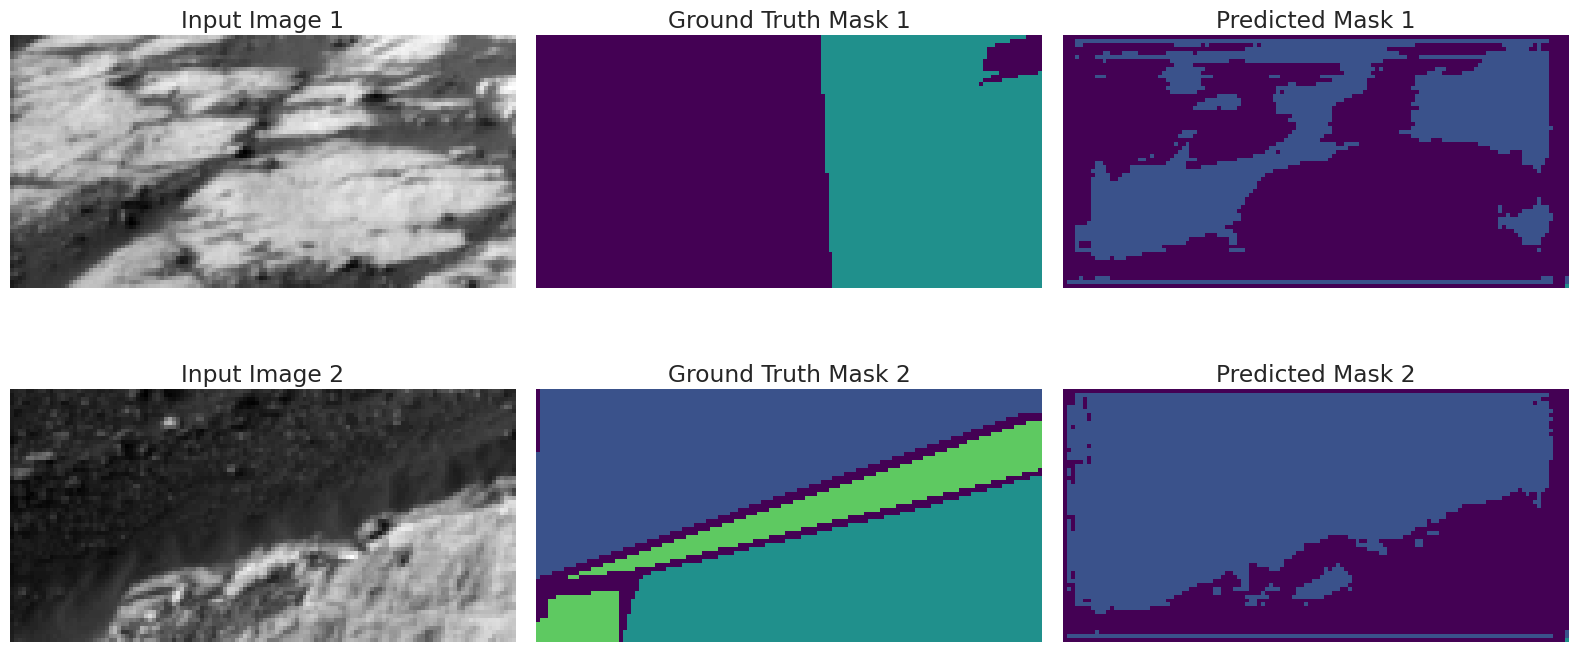

32/32 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.2393 - loss: 0.0104 - mean_iou: 0.0806 - val_accuracy: 0.2532 - val_loss: 0.0067 - val_mean_iou: 0.0547
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.2865 - loss: 0.0072 - mean_iou: 0.1324 - val_accuracy: 0.2200 - val_loss: 0.0068 - val_mean_iou: 0.0608
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.3606 - loss: 0.0058 - mean_iou: 0.1943 - val_accuracy: 0.2164 - val_loss: 0.0083 - val_mean_iou: 0.0575
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.3605 - loss: 0.0054 - mean_iou: 0.1996 - val_accuracy: 0.2159 - val_loss: 0.0093 - val_mean_iou: 0.0571
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.4137 - loss: 0.0049 - mean_iou: 0.2352 - val_accuracy: 0.2149 - val_loss: 0.0088 - val_mean_iou: 0.0574
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4691 - loss: 0.0046 - mean_iou: 0.2728

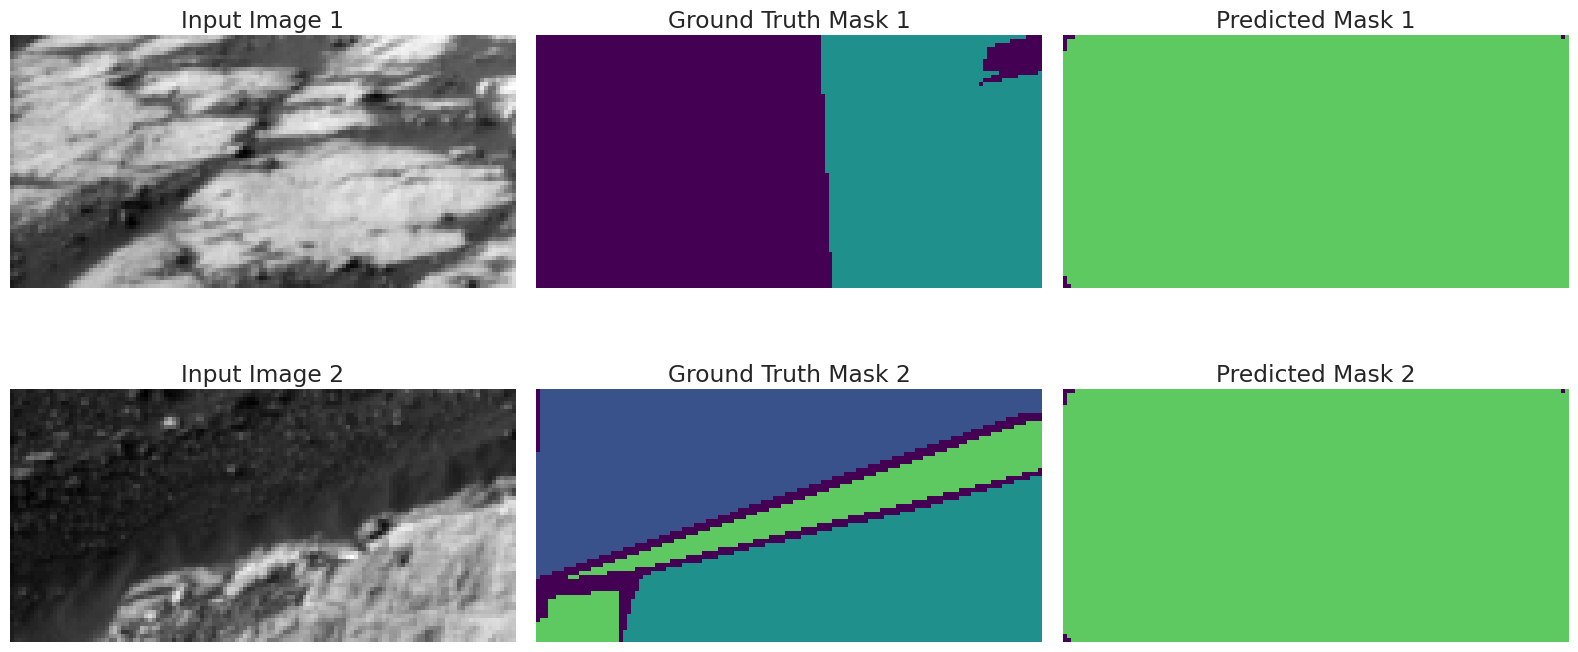

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.4692 - loss: 0.0046 - mean_iou: 0.2728 - val_accuracy: 0.2132 - val_loss: 0.0146 - val_mean_iou: 0.0573
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.4786 - loss: 0.0049 - mean_iou: 0.2774 - val_accuracy: 0.2148 - val_loss: 0.0140 - val_mean_iou: 0.0572
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.4843 - loss: 0.0044 - mean_iou: 0.2705 - val_accuracy: 0.2130 - val_loss: 0.0227 - val_mean_iou: 0.0574
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.5048 - loss: 0.0042 - mean_iou: 0.2926 - val_accuracy: 0.2140 - val_loss: 0.0157 - val_mean_iou: 0.0574
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.4657 - loss: 0.0048 - mean_iou: 0.2477 - val_accuracy: 0.2130 - val_loss: 0.0247 - val_mean_iou: 0.0573
Epoch 11/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5032 - loss: 0.0042 - mean_iou: 0.2885

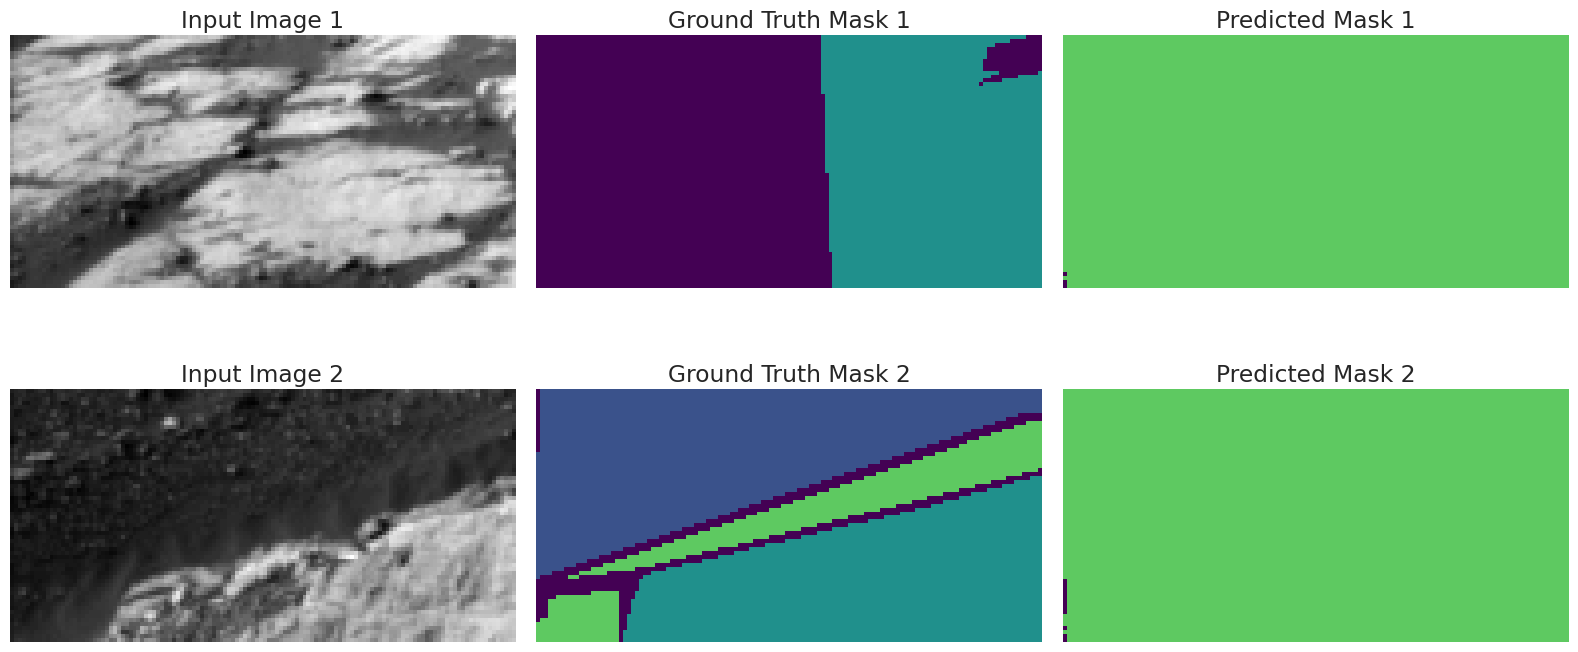

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.5032 - loss: 0.0042 - mean_iou: 0.2884 - val_accuracy: 0.2131 - val_loss: 0.0318 - val_mean_iou: 0.0572
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.5057 - loss: 0.0040 - mean_iou: 0.3019 - val_accuracy: 0.2390 - val_loss: 0.0165 - val_mean_iou: 0.0747
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5450 - loss: 0.0039 - mean_iou: 0.3018 - val_accuracy: 0.2437 - val_loss: 0.0163 - val_mean_iou: 0.0775
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.5568 - loss: 0.0037 - mean_iou: 0.3252 - val_accuracy: 0.2213 - val_loss: 0.0257 - val_mean_iou: 0.0627
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5048 - loss: 0.0041 - mean_iou: 0.2968 - val_accuracy: 0.2986 - val_loss: 0.0080 - val_mean_iou: 0.1234
Epoch 16/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5538 - loss: 0.0036 - mean_iou: 0.3165

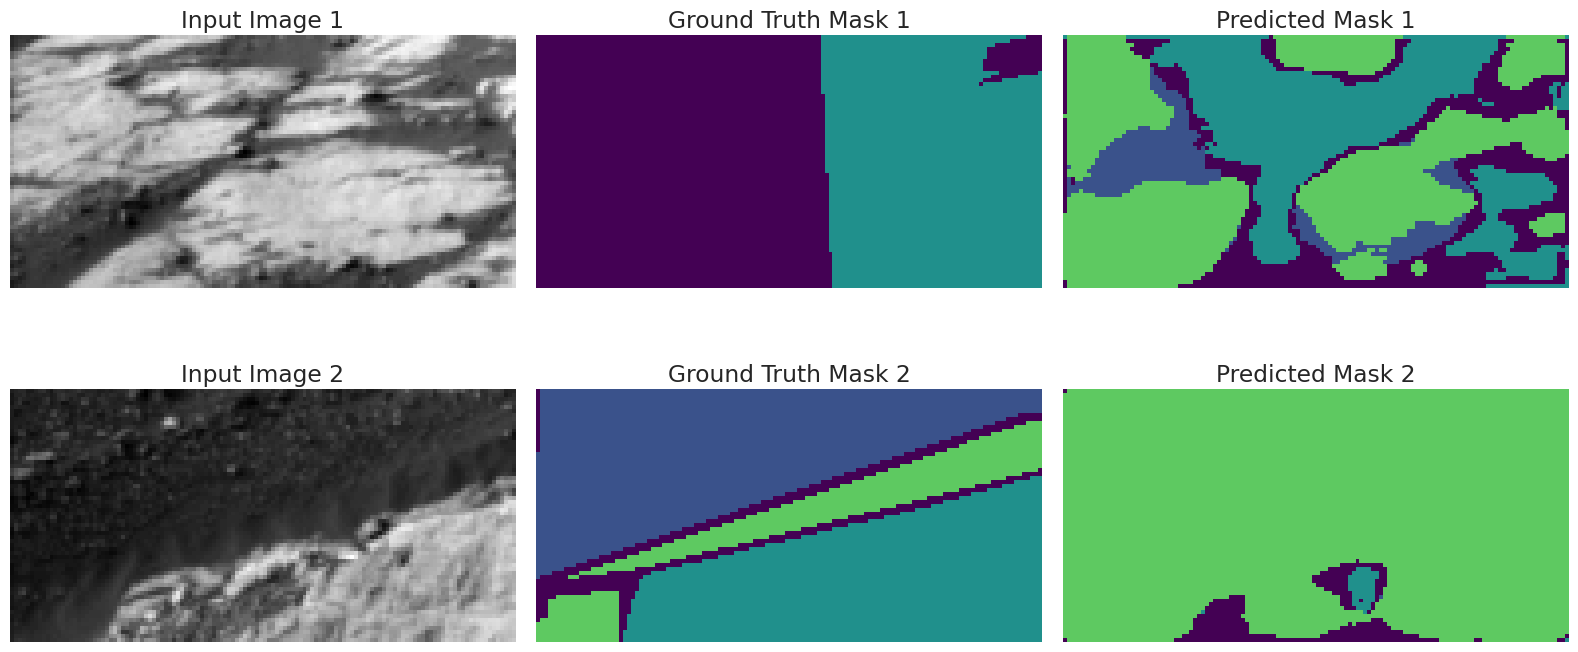

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.5537 - loss: 0.0036 - mean_iou: 0.3163 - val_accuracy: 0.3963 - val_loss: 0.0074 - val_mean_iou: 0.2248
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5524 - loss: 0.0035 - mean_iou: 0.3231 - val_accuracy: 0.5432 - val_loss: 0.0040 - val_mean_iou: 0.3390
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.5342 - loss: 0.0041 - mean_iou: 0.3060 - val_accuracy: 0.2505 - val_loss: 0.0659 - val_mean_iou: 0.0067
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.4440 - loss: 0.0045 - mean_iou: 0.2463 - val_accuracy: 0.3304 - val_loss: 0.0470 - val_mean_iou: 0.0887
Epoch 20/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.5088 - loss: 0.0038 - mean_iou: 0.2906 - val_accuracy: 0.5488 - val_loss: 0.0037 - val_mean_iou: 0.2970
Epoch 21/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5814 - loss: 0.0034 - mean_iou: 0.3525

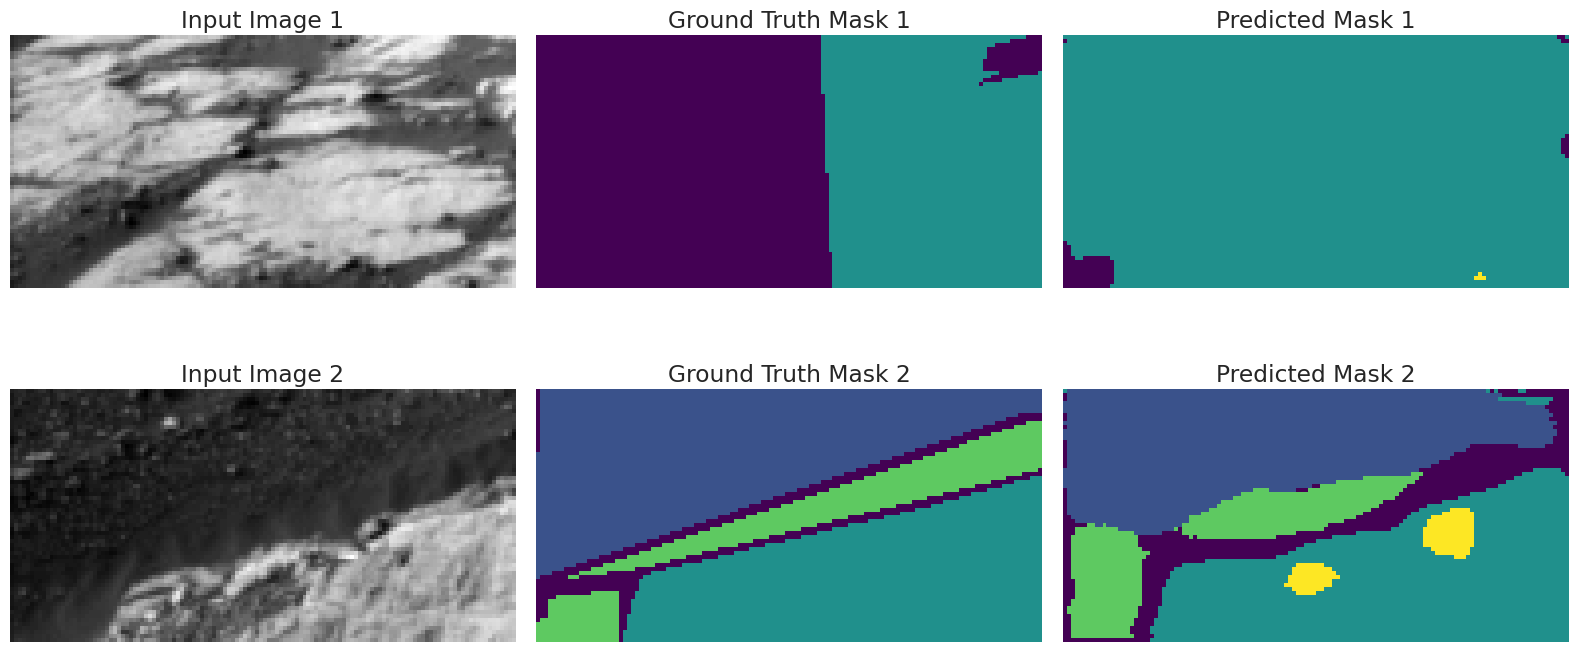

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.5811 - loss: 0.0034 - mean_iou: 0.3522 - val_accuracy: 0.5506 - val_loss: 0.0033 - val_mean_iou: 0.3369
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.5687 - loss: 0.0033 - mean_iou: 0.3451 - val_accuracy: 0.5142 - val_loss: 0.0055 - val_mean_iou: 0.2601
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.6161 - loss: 0.0031 - mean_iou: 0.3781 - val_accuracy: 0.4971 - val_loss: 0.0054 - val_mean_iou: 0.2518
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.5860 - loss: 0.0030 - mean_iou: 0.3456 - val_accuracy: 0.5232 - val_loss: 0.0041 - val_mean_iou: 0.3271
Epoch 25/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.6208 - loss: 0.0029 - mean_iou: 0.3790 - val_accuracy: 0.4397 - val_loss: 0.0046 - val_mean_iou: 0.2503
Epoch 26/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5877 - loss: 0.0032 - mean_iou: 0.3677

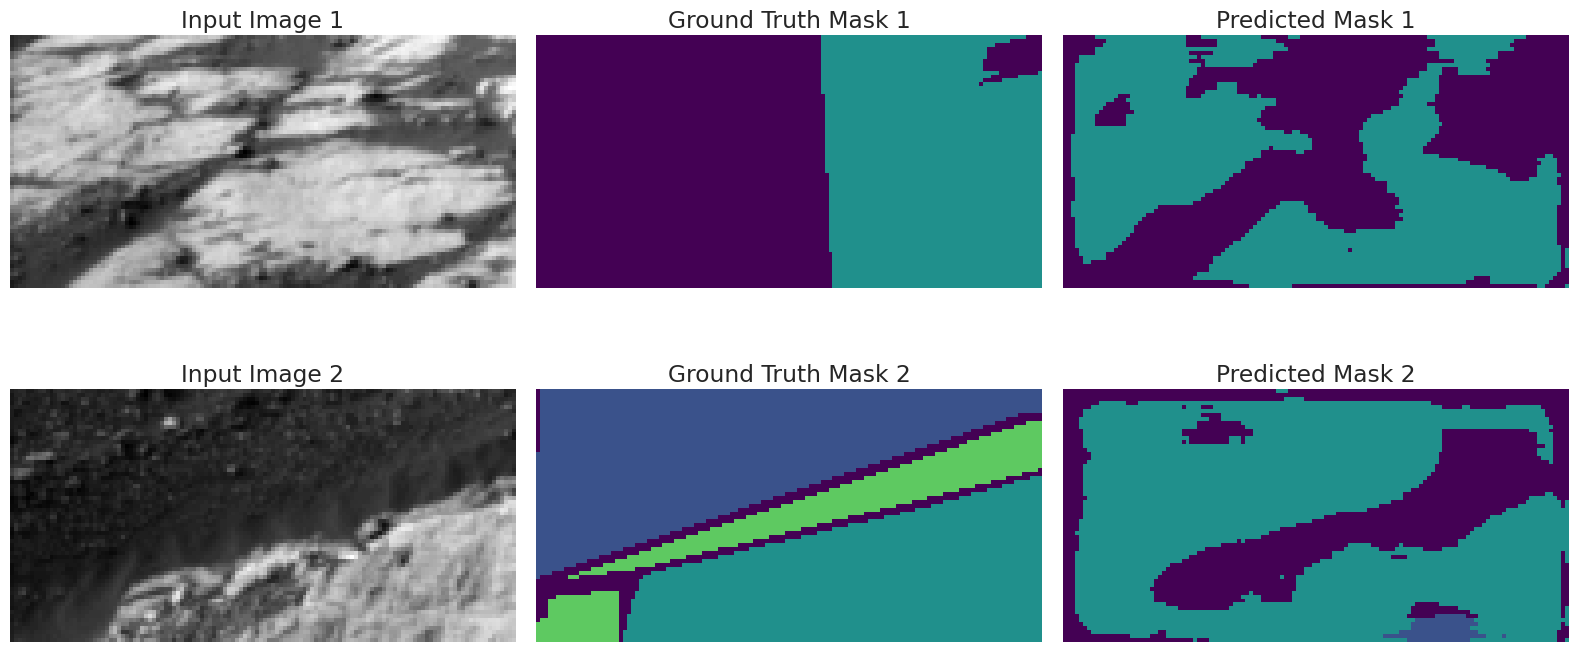

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - accuracy: 0.5873 - loss: 0.0032 - mean_iou: 0.3672 - val_accuracy: 0.3854 - val_loss: 0.0120 - val_mean_iou: 0.1323
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.5592 - loss: 0.0034 - mean_iou: 0.3368 - val_accuracy: 0.2313 - val_loss: 0.0165 - val_mean_iou: 0.0427
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.6189 - loss: 0.0029 - mean_iou: 0.3850 - val_accuracy: 0.3601 - val_loss: 0.0073 - val_mean_iou: 0.1562
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.6359 - loss: 0.0028 - mean_iou: 0.3862 - val_accuracy: 0.5407 - val_loss: 0.0041 - val_mean_iou: 0.2806
Epoch 30/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.6617 - loss: 0.0025 - mean_iou: 0.4103 - val_accuracy: 0.5832 - val_loss: 0.0034 - val_mean_iou: 0.3216
Epoch 31/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6225 - loss: 0.0029 - mean_iou: 0.3715

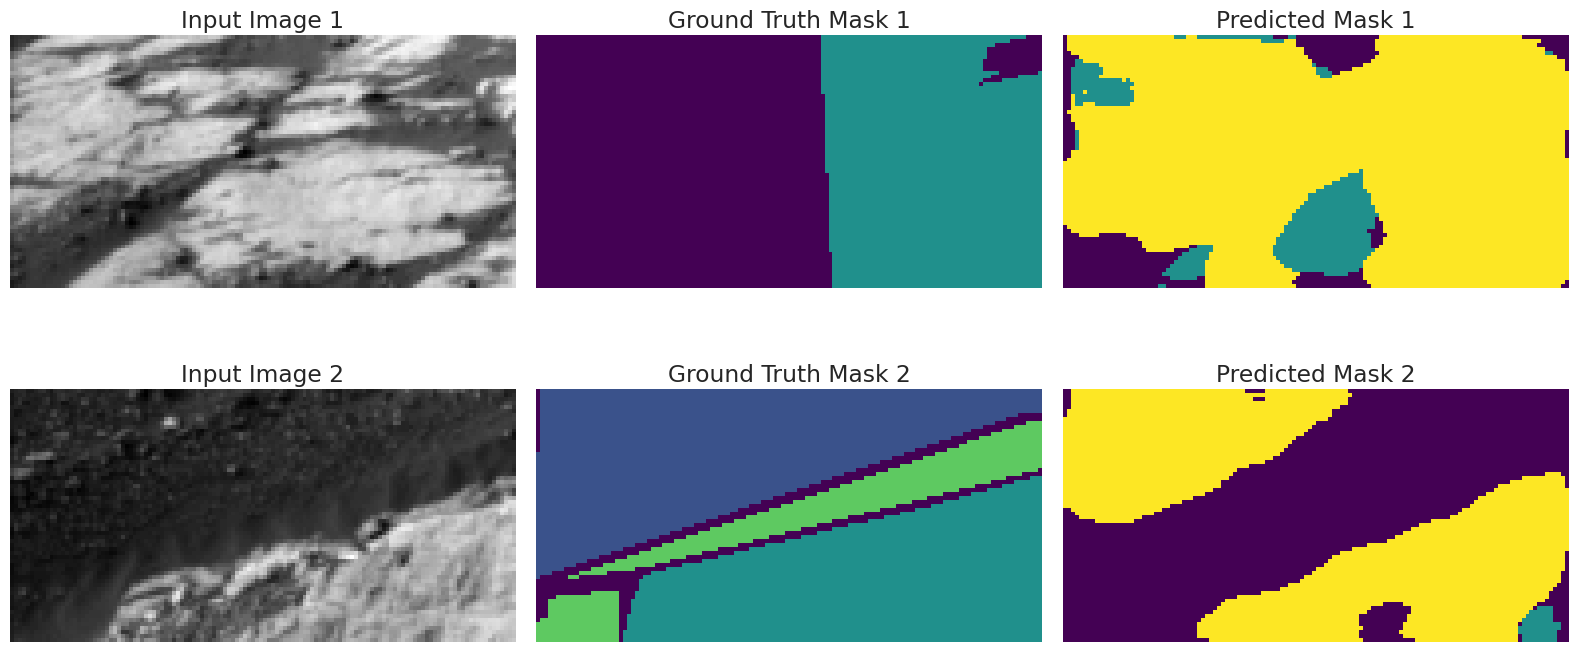

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.6224 - loss: 0.0029 - mean_iou: 0.3714 - val_accuracy: 0.4994 - val_loss: 0.0061 - val_mean_iou: 0.2702
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.5881 - loss: 0.0030 - mean_iou: 0.3490 - val_accuracy: 0.5892 - val_loss: 0.0032 - val_mean_iou: 0.3384
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.6620 - loss: 0.0026 - mean_iou: 0.4138 - val_accuracy: 0.5279 - val_loss: 0.0039 - val_mean_iou: 0.3265
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.6474 - loss: 0.0025 - mean_iou: 0.4089 - val_accuracy: 0.4943 - val_loss: 0.0036 - val_mean_iou: 0.2754
Epoch 35/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.6610 - loss: 0.0024 - mean_iou: 0.4123 - val_accuracy: 0.6758 - val_loss: 0.0031 - val_mean_iou: 0.4257
Epoch 36/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6681 - loss: 0.0024 - mean_iou: 0.4183

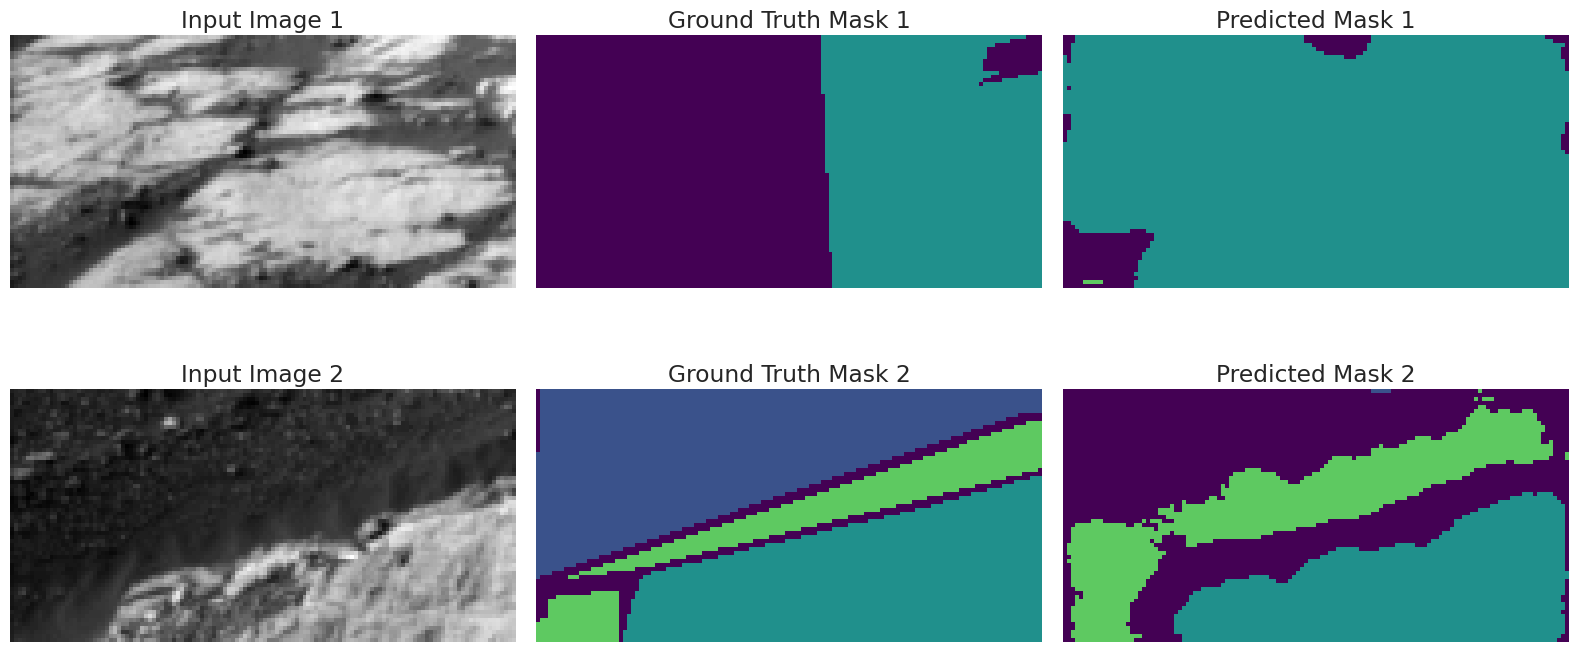

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - accuracy: 0.6681 - loss: 0.0024 - mean_iou: 0.4181 - val_accuracy: 0.6122 - val_loss: 0.0033 - val_mean_iou: 0.3496
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.6546 - loss: 0.0024 - mean_iou: 0.4006 - val_accuracy: 0.5746 - val_loss: 0.0033 - val_mean_iou: 0.3583
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.6857 - loss: 0.0023 - mean_iou: 0.4376 - val_accuracy: 0.5392 - val_loss: 0.0033 - val_mean_iou: 0.3069
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.6698 - loss: 0.0023 - mean_iou: 0.4191 - val_accuracy: 0.6722 - val_loss: 0.0031 - val_mean_iou: 0.4296
Epoch 40/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.7033 - loss: 0.0020 - mean_iou: 0.4593 - val_accuracy: 0.5573 - val_loss: 0.0040 - val_mean_iou: 0.3440
Epoch 41/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5672 - loss: 0.0038 - mean_iou: 0.3245

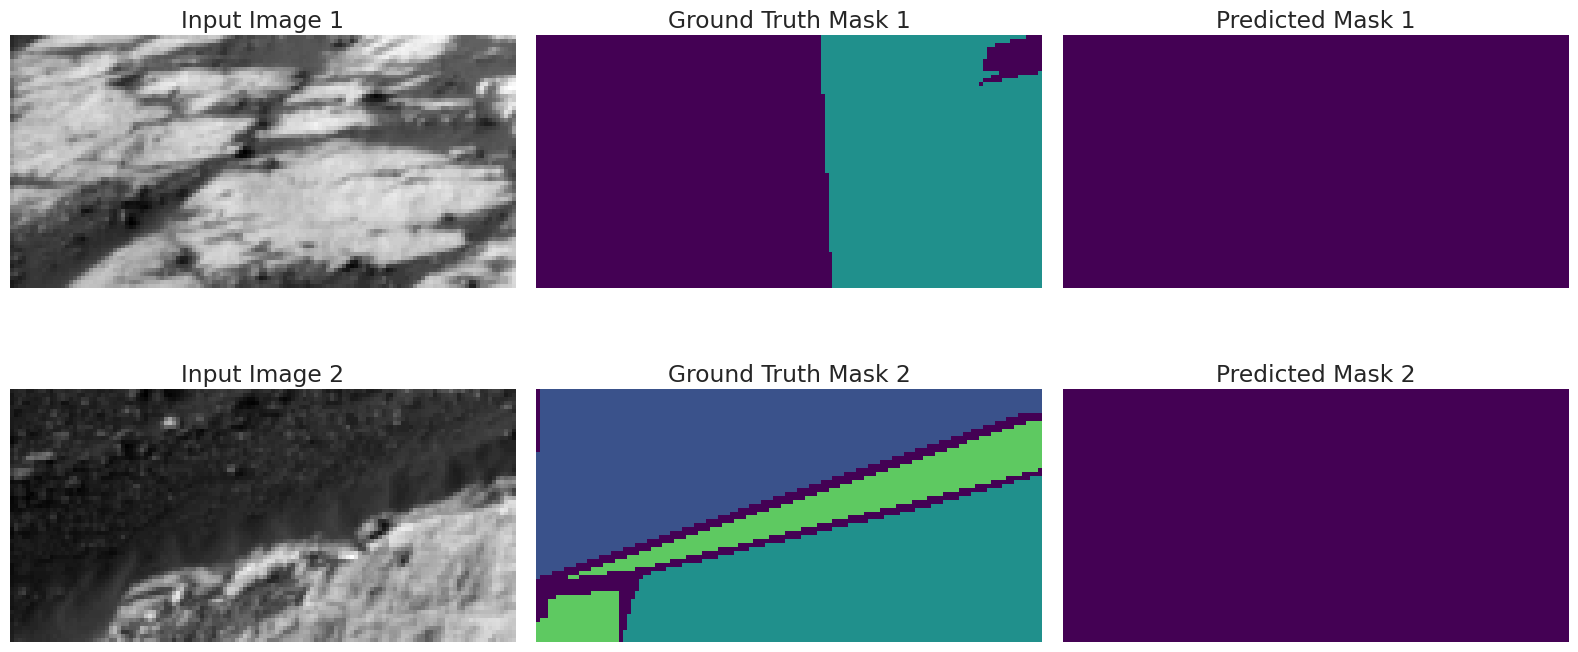

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.5665 - loss: 0.0038 - mean_iou: 0.3239 - val_accuracy: 0.2796 - val_loss: 0.0676 - val_mean_iou: 0.0256
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5904 - loss: 0.0032 - mean_iou: 0.3545 - val_accuracy: 0.3125 - val_loss: 0.0082 - val_mean_iou: 0.1941
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.6165 - loss: 0.0027 - mean_iou: 0.3911 - val_accuracy: 0.5462 - val_loss: 0.0040 - val_mean_iou: 0.3209
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.6529 - loss: 0.0025 - mean_iou: 0.4126 - val_accuracy: 0.6422 - val_loss: 0.0029 - val_mean_iou: 0.4003
Epoch 45/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.6346 - loss: 0.0027 - mean_iou: 0.3876 - val_accuracy: 0.4459 - val_loss: 0.0095 - val_mean_iou: 0.1998
Epoch 46/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6591 - loss: 0.0023 - mean_iou: 0.4060

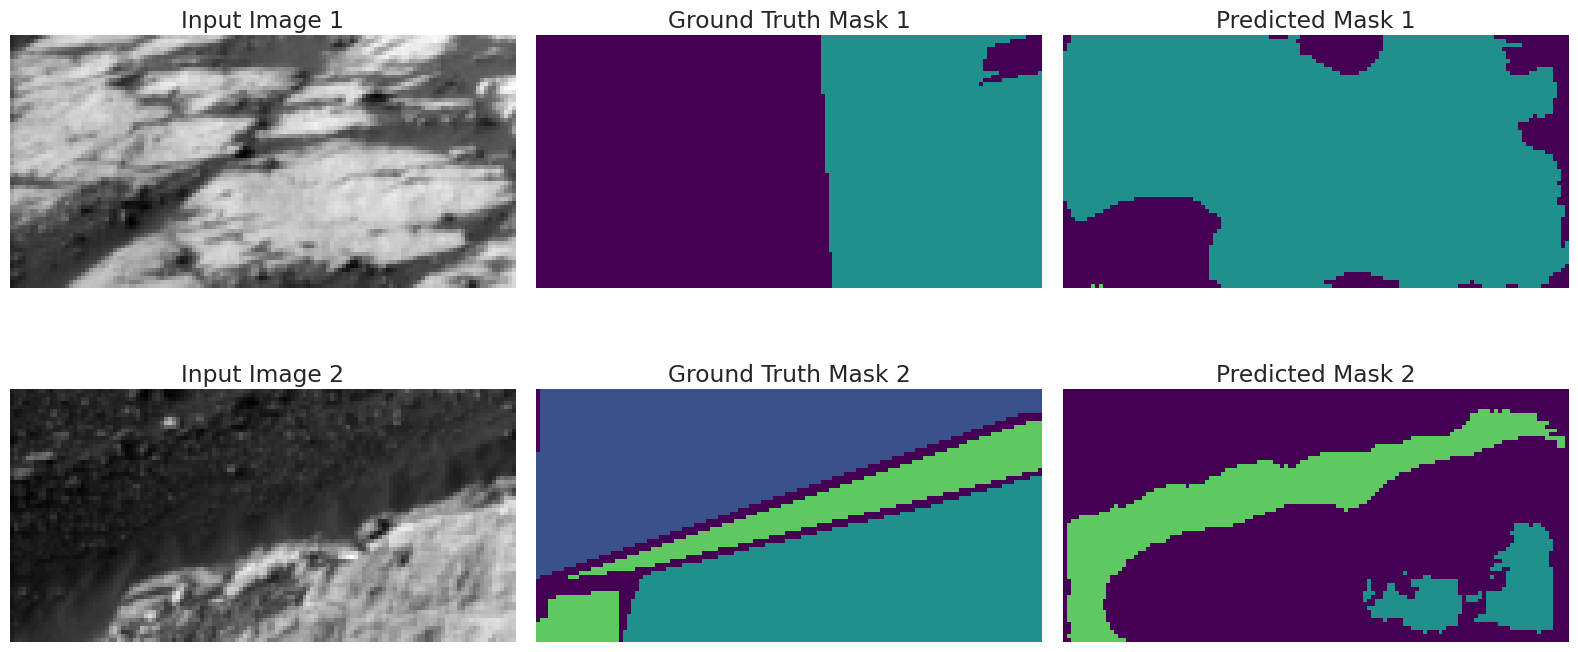

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.6593 - loss: 0.0023 - mean_iou: 0.4060 - val_accuracy: 0.6133 - val_loss: 0.0039 - val_mean_iou: 0.3471
Epoch 47/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.6331 - loss: 0.0033 - mean_iou: 0.3897 - val_accuracy: 0.4803 - val_loss: 0.0057 - val_mean_iou: 0.2406
Epoch 48/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.6360 - loss: 0.0026 - mean_iou: 0.4013 - val_accuracy: 0.6625 - val_loss: 0.0036 - val_mean_iou: 0.4264
Epoch 49/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.6794 - loss: 0.0023 - mean_iou: 0.4293 - val_accuracy: 0.6575 - val_loss: 0.0026 - val_mean_iou: 0.4116
Epoch 50/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.6908 - loss: 0.0022 - mean_iou: 0.4482 - val_accuracy: 0.6582 - val_loss: 0.0030 - val_mean_iou: 0.4103
Epoch 51/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6754 - loss: 0.0023 - mean_iou: 0.4232

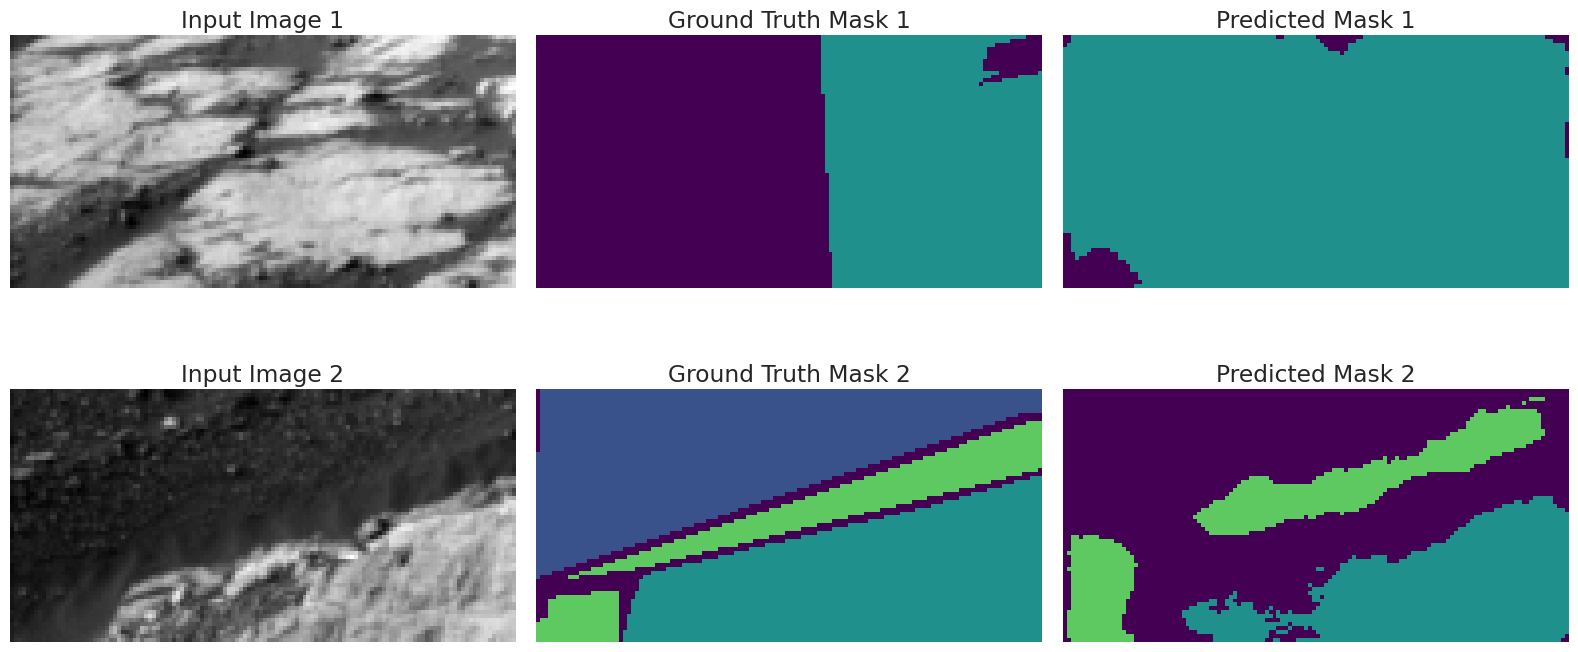

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step - accuracy: 0.6752 - loss: 0.0023 - mean_iou: 0.4230 - val_accuracy: 0.5249 - val_loss: 0.0038 - val_mean_iou: 0.2920
Epoch 52/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.6969 - loss: 0.0022 - mean_iou: 0.4405 - val_accuracy: 0.6883 - val_loss: 0.0025 - val_mean_iou: 0.4461
Epoch 53/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.7146 - loss: 0.0020 - mean_iou: 0.4695 - val_accuracy: 0.7064 - val_loss: 0.0022 - val_mean_iou: 0.4618
Epoch 54/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.7140 - loss: 0.0019 - mean_iou: 0.4735 - val_accuracy: 0.6669 - val_loss: 0.0023 - val_mean_iou: 0.4274
Epoch 55/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.7154 - loss: 0.0019 - mean_iou: 0.4695 - val_accuracy: 0.7110 - val_loss: 0.0022 - val_mean_iou: 0.4706
Epoch 56/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7141 - loss: 0.0019 - mean_iou: 0.4689

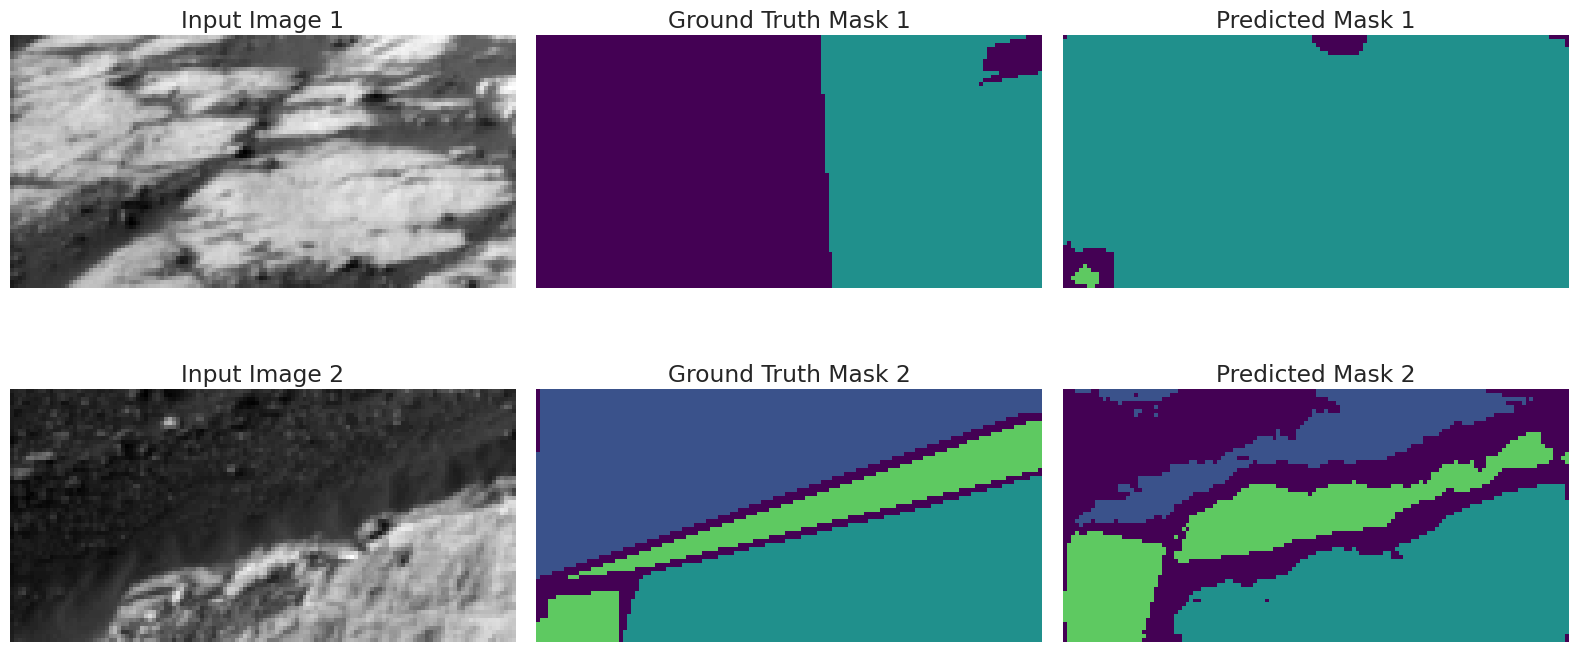

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.7141 - loss: 0.0019 - mean_iou: 0.4687 - val_accuracy: 0.7036 - val_loss: 0.0024 - val_mean_iou: 0.4871
Epoch 57/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.7246 - loss: 0.0018 - mean_iou: 0.4811 - val_accuracy: 0.6932 - val_loss: 0.0029 - val_mean_iou: 0.4715
Epoch 58/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.7329 - loss: 0.0017 - mean_iou: 0.4949 - val_accuracy: 0.6960 - val_loss: 0.0022 - val_mean_iou: 0.4640
Epoch 59/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.7228 - loss: 0.0018 - mean_iou: 0.4988 - val_accuracy: 0.7280 - val_loss: 0.0026 - val_mean_iou: 0.4877
Epoch 60/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.7286 - loss: 0.0017 - mean_iou: 0.4973 - val_accuracy: 0.7228 - val_loss: 0.0024 - val_mean_iou: 0.4679
Epoch 61/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7337 - loss: 0.0017 - mean_iou: 0.4998

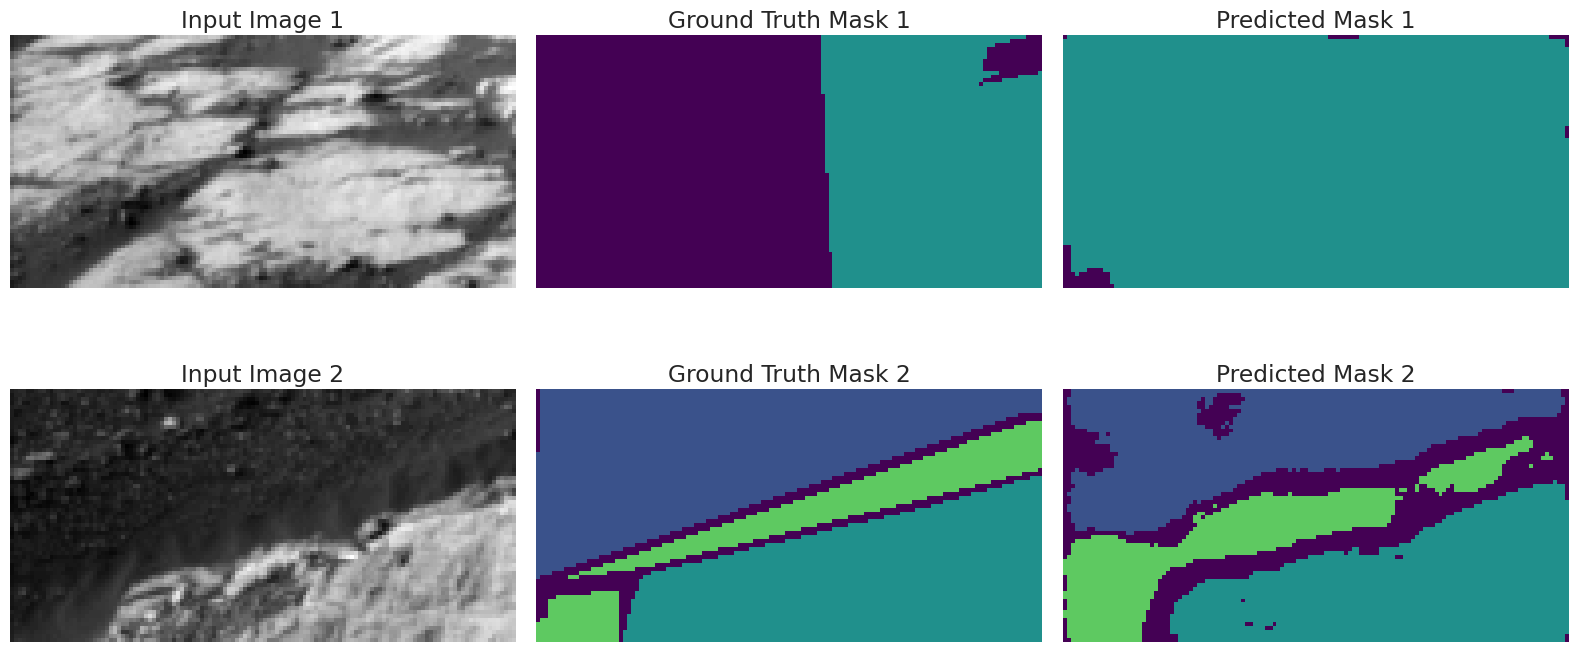

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0.7338 - loss: 0.0017 - mean_iou: 0.4996 - val_accuracy: 0.7056 - val_loss: 0.0030 - val_mean_iou: 0.4718
Epoch 62/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.7067 - loss: 0.0021 - mean_iou: 0.4559 - val_accuracy: 0.4966 - val_loss: 0.0051 - val_mean_iou: 0.2741
Epoch 63/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.6489 - loss: 0.0024 - mean_iou: 0.4110 - val_accuracy: 0.4949 - val_loss: 0.0052 - val_mean_iou: 0.3121
Epoch 64/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.6812 - loss: 0.0022 - mean_iou: 0.4327 - val_accuracy: 0.6269 - val_loss: 0.0026 - val_mean_iou: 0.3982
Epoch 65/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.7131 - loss: 0.0019 - mean_iou: 0.4642 - val_accuracy: 0.7094 - val_loss: 0.0024 - val_mean_iou: 0.4845
Epoch 66/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7333 - loss: 0.0017 - mean_iou: 0.4918

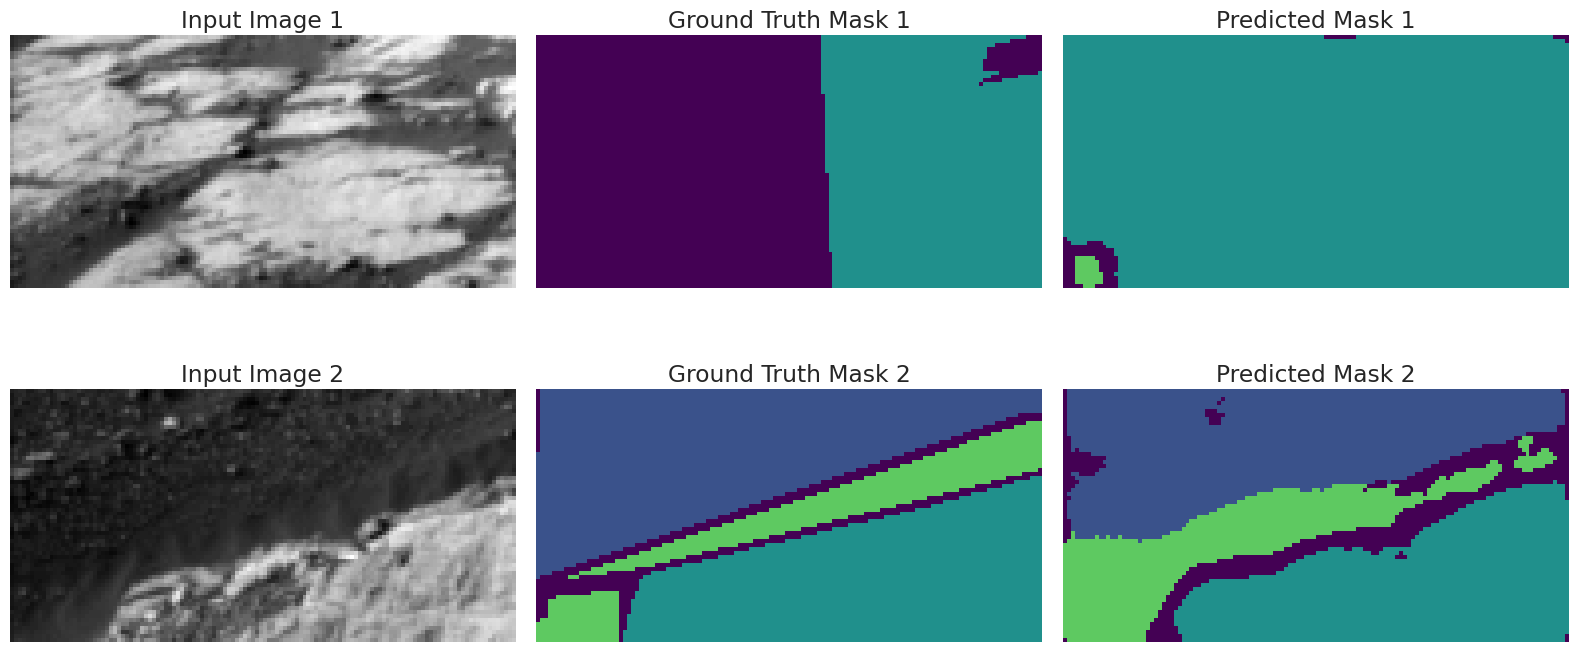

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.7332 - loss: 0.0017 - mean_iou: 0.4913 - val_accuracy: 0.7149 - val_loss: 0.0029 - val_mean_iou: 0.5058
Epoch 67/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.7354 - loss: 0.0017 - mean_iou: 0.4969 - val_accuracy: 0.7081 - val_loss: 0.0030 - val_mean_iou: 0.4731
Epoch 68/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.7133 - loss: 0.0018 - mean_iou: 0.4763 - val_accuracy: 0.6647 - val_loss: 0.0030 - val_mean_iou: 0.4527
Epoch 69/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.7272 - loss: 0.0017 - mean_iou: 0.4894 - val_accuracy: 0.6980 - val_loss: 0.0023 - val_mean_iou: 0.4707
Epoch 70/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.7446 - loss: 0.0016 - mean_iou: 0.5160 - val_accuracy: 0.7195 - val_loss: 0.0025 - val_mean_iou: 0.4821
Epoch 71/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7402 - loss: 0.0015 - mean_iou: 0.5099

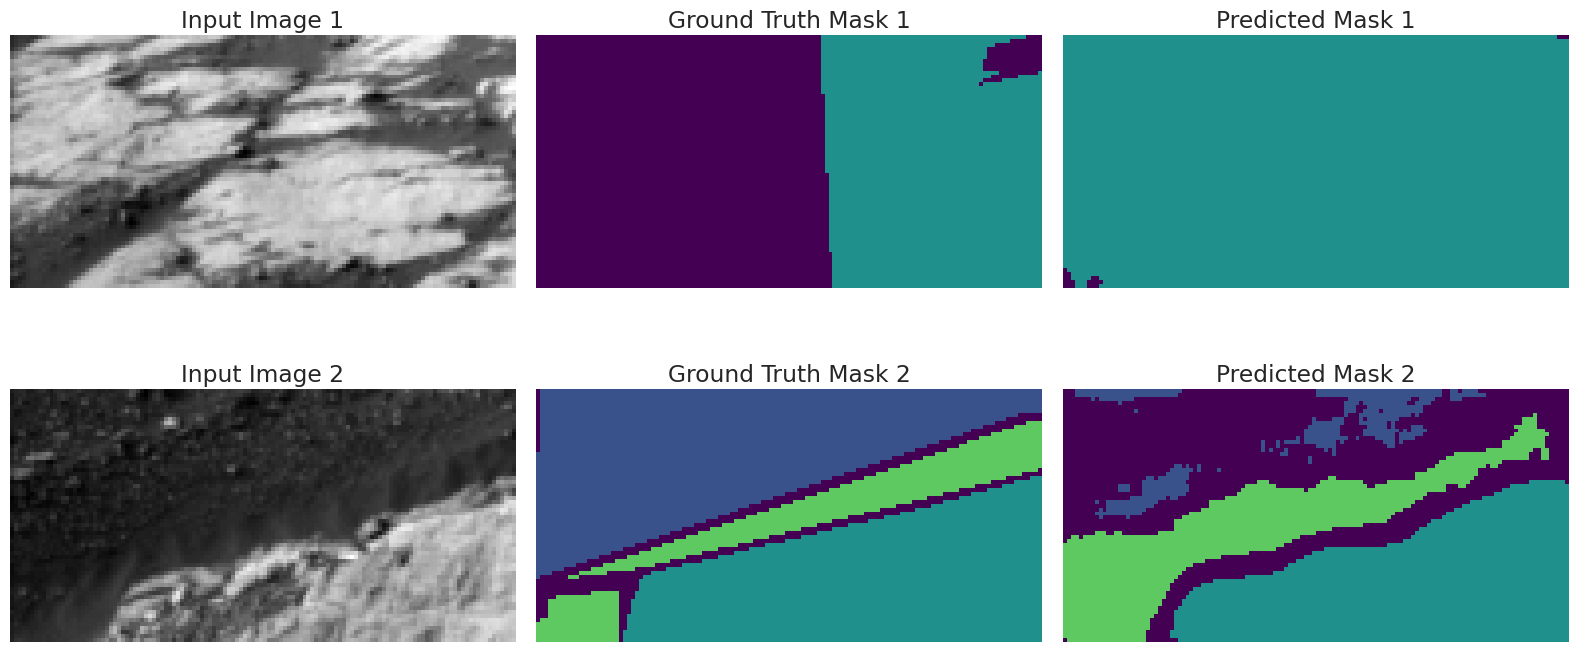

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.7405 - loss: 0.0015 - mean_iou: 0.5100 - val_accuracy: 0.7286 - val_loss: 0.0027 - val_mean_iou: 0.5134
Epoch 72/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.7511 - loss: 0.0015 - mean_iou: 0.5464 - val_accuracy: 0.7258 - val_loss: 0.0028 - val_mean_iou: 0.5027
Epoch 73/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.7441 - loss: 0.0015 - mean_iou: 0.5155 - val_accuracy: 0.7380 - val_loss: 0.0021 - val_mean_iou: 0.5104
Epoch 74/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.7573 - loss: 0.0015 - mean_iou: 0.5325 - val_accuracy: 0.7316 - val_loss: 0.0026 - val_mean_iou: 0.4902
Epoch 75/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.7535 - loss: 0.0014 - mean_iou: 0.5459 - val_accuracy: 0.7264 - val_loss: 0.0028 - val_mean_iou: 0.4981
Epoch 76/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7647 - loss: 0.0014 - mean_iou: 0.5704

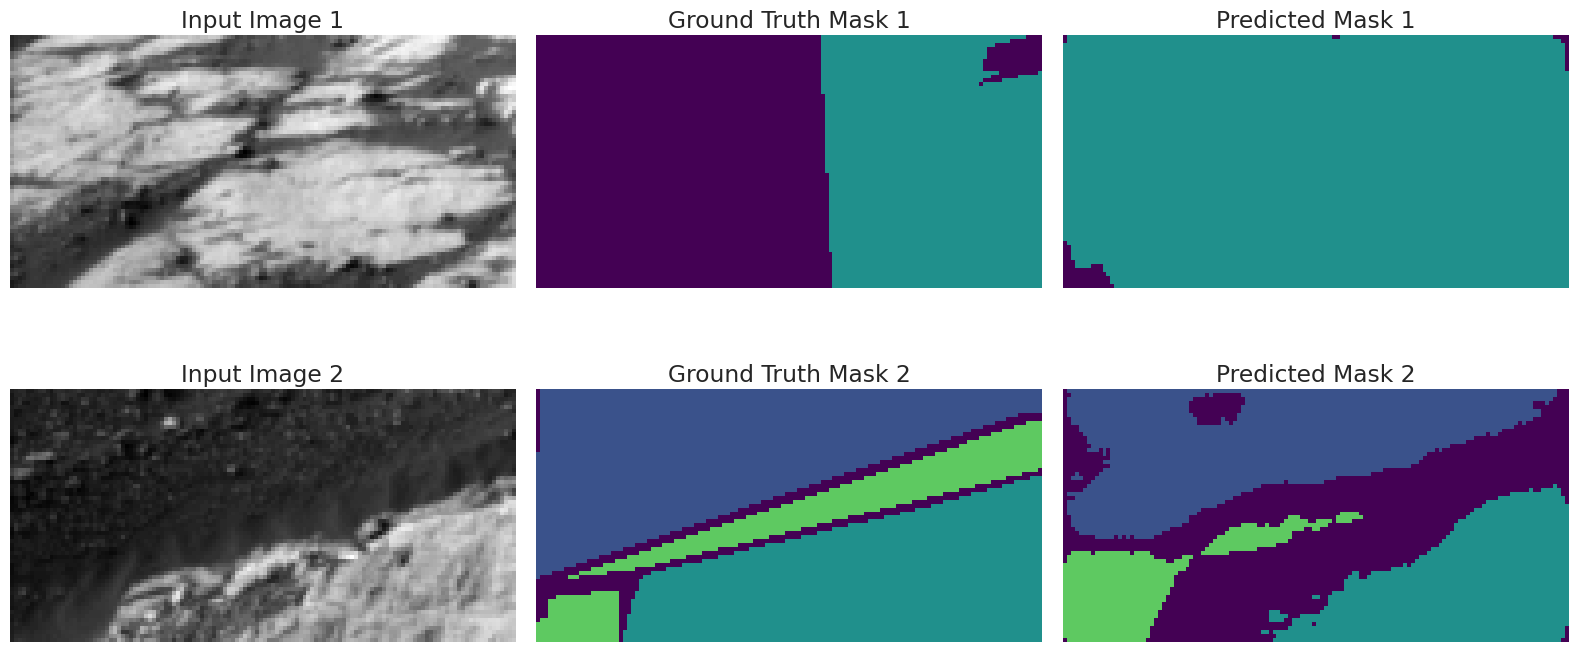

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.7647 - loss: 0.0014 - mean_iou: 0.5701 - val_accuracy: 0.7157 - val_loss: 0.0031 - val_mean_iou: 0.4932
Epoch 77/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.7283 - loss: 0.0017 - mean_iou: 0.5113 - val_accuracy: 0.7202 - val_loss: 0.0030 - val_mean_iou: 0.5037
Epoch 78/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.7462 - loss: 0.0015 - mean_iou: 0.5451 - val_accuracy: 0.7352 - val_loss: 0.0024 - val_mean_iou: 0.5147
Epoch 79/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.7570 - loss: 0.0014 - mean_iou: 0.5538 - val_accuracy: 0.7414 - val_loss: 0.0025 - val_mean_iou: 0.5317
Epoch 80/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.7698 - loss: 0.0013 - mean_iou: 0.5731 - val_accuracy: 0.7374 - val_loss: 0.0025 - val_mean_iou: 0.5463
Epoch 81/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7652 - loss: 0.0014 - mean_iou: 0.5721

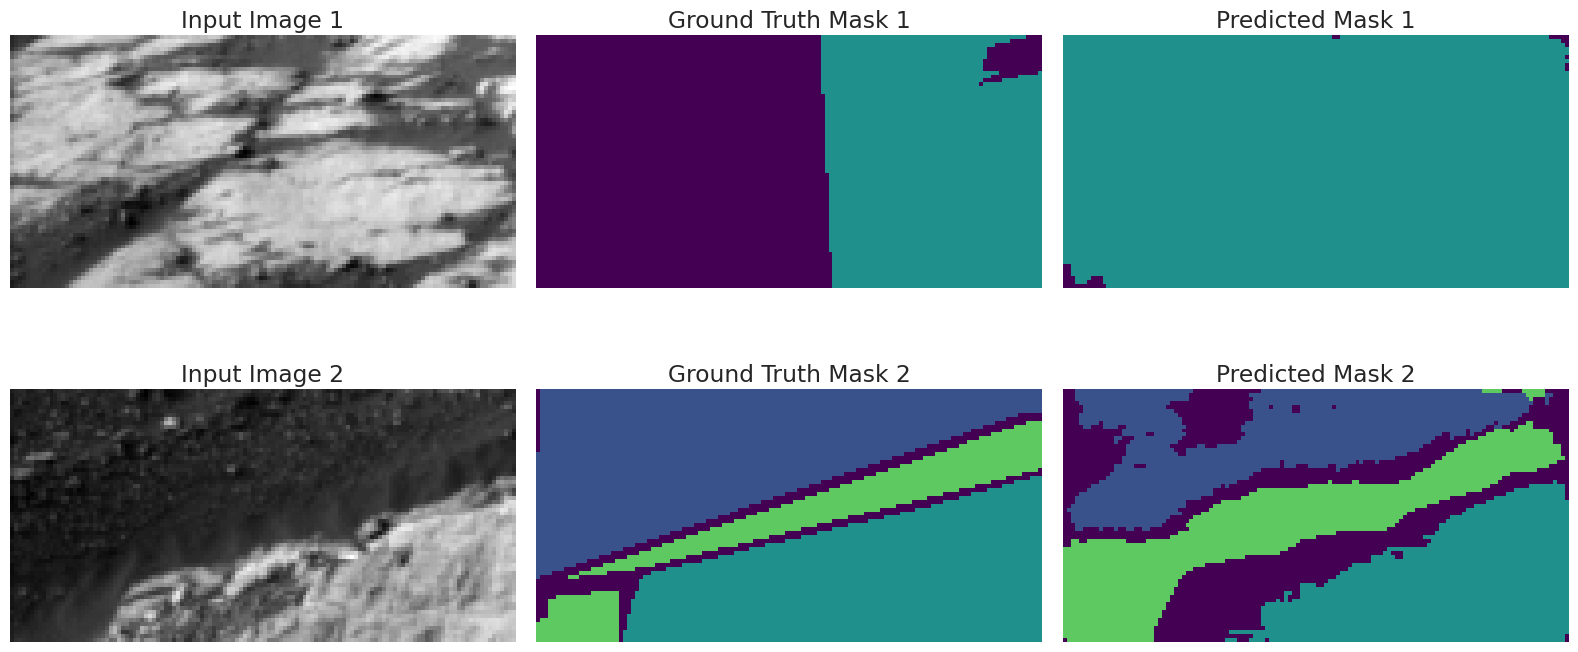

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.7653 - loss: 0.0014 - mean_iou: 0.5721 - val_accuracy: 0.7456 - val_loss: 0.0027 - val_mean_iou: 0.5373
Epoch 82/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.7703 - loss: 0.0013 - mean_iou: 0.5868 - val_accuracy: 0.7226 - val_loss: 0.0026 - val_mean_iou: 0.4789
Epoch 83/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.7634 - loss: 0.0014 - mean_iou: 0.5469 - val_accuracy: 0.7502 - val_loss: 0.0028 - val_mean_iou: 0.5360
Epoch 84/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.7665 - loss: 0.0014 - mean_iou: 0.5684 - val_accuracy: 0.7495 - val_loss: 0.0028 - val_mean_iou: 0.5481
Epoch 85/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.7661 - loss: 0.0014 - mean_iou: 0.5549 - val_accuracy: 0.5910 - val_loss: 0.0041 - val_mean_iou: 0.3595
Epoch 86/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7340 - loss: 0.0016 - mean_iou: 0.5024

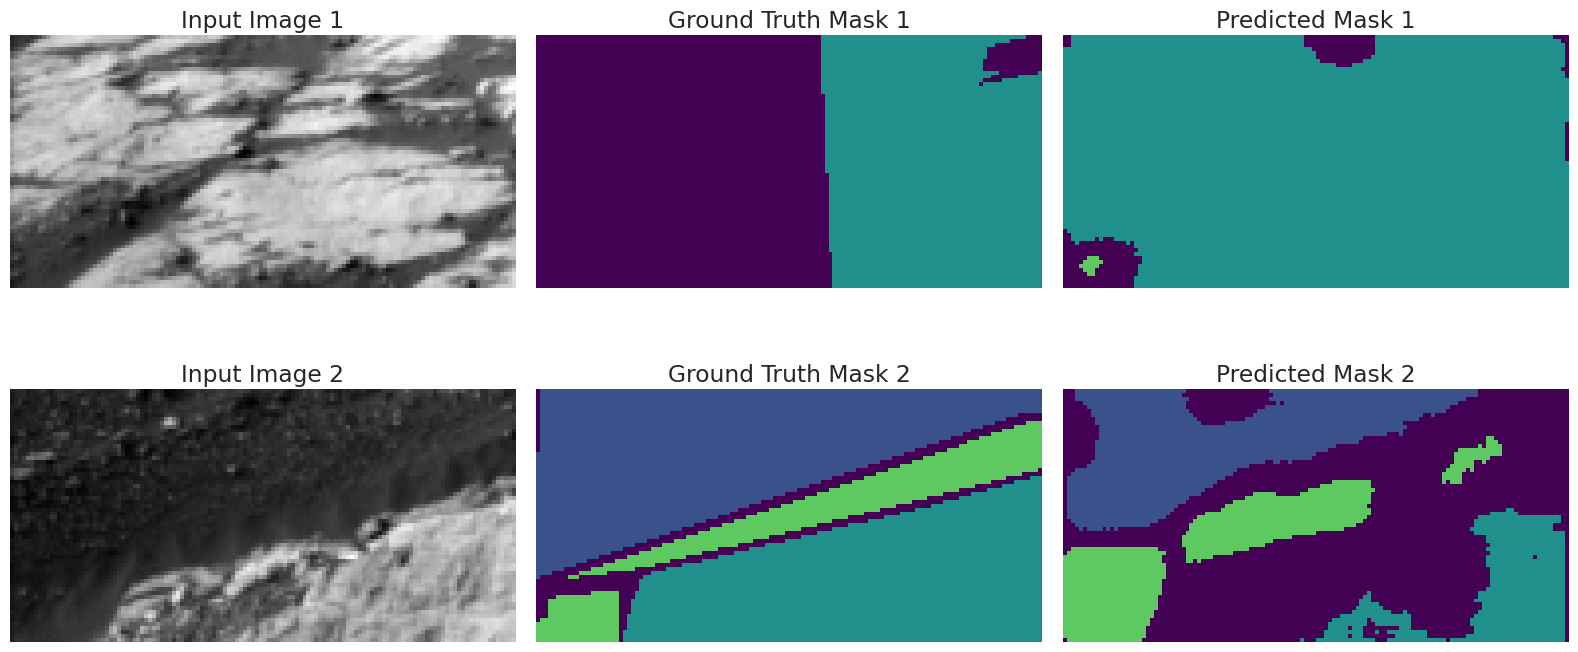

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.7343 - loss: 0.0016 - mean_iou: 0.5023 - val_accuracy: 0.6978 - val_loss: 0.0031 - val_mean_iou: 0.4273
Epoch 87/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.7505 - loss: 0.0014 - mean_iou: 0.5181 - val_accuracy: 0.7264 - val_loss: 0.0026 - val_mean_iou: 0.4664
Epoch 88/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.7660 - loss: 0.0013 - mean_iou: 0.5463 - val_accuracy: 0.7302 - val_loss: 0.0027 - val_mean_iou: 0.4854
Epoch 89/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.7768 - loss: 0.0013 - mean_iou: 0.5763 - val_accuracy: 0.7342 - val_loss: 0.0025 - val_mean_iou: 0.4962
Epoch 90/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.7745 - loss: 0.0013 - mean_iou: 0.5725 - val_accuracy: 0.7368 - val_loss: 0.0027 - val_mean_iou: 0.5081
Epoch 91/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7760 - loss: 0.0013 - mean_iou: 0.5720

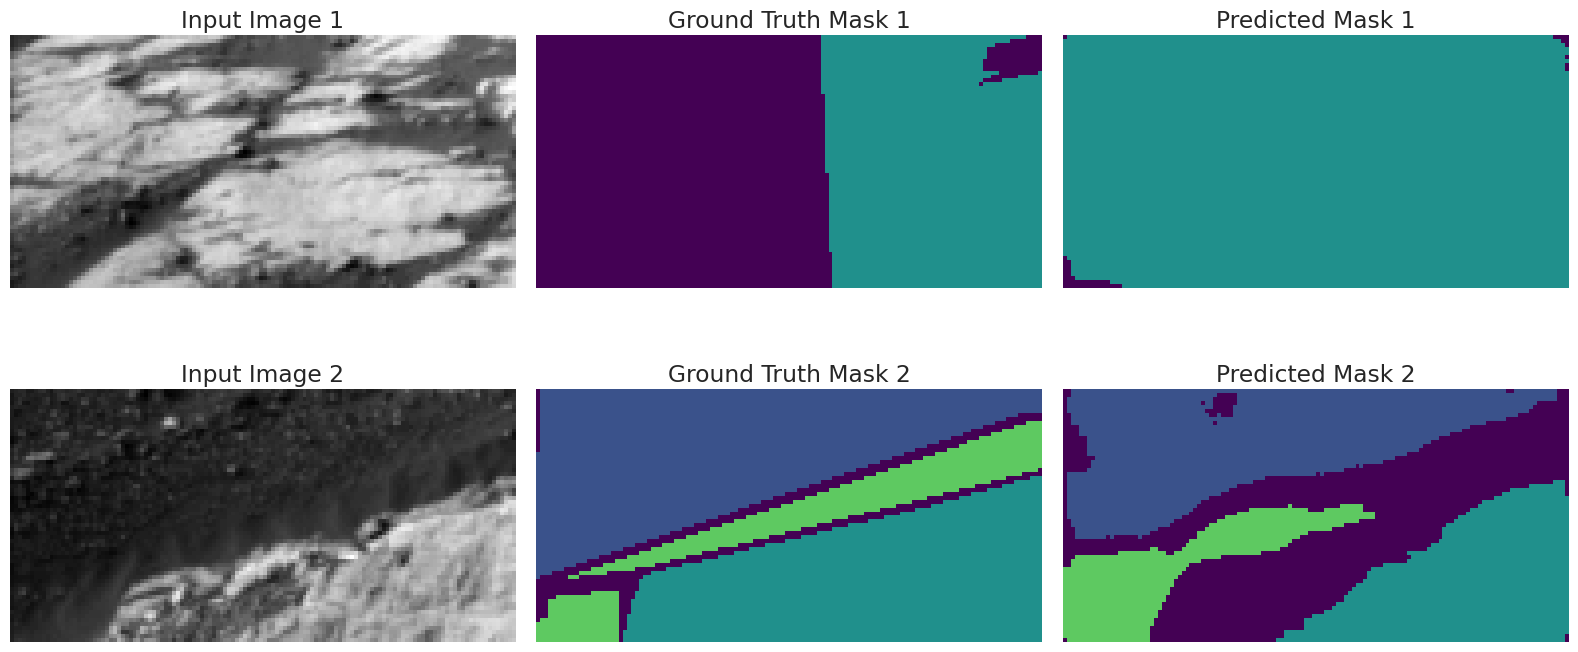

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.7761 - loss: 0.0013 - mean_iou: 0.5719 - val_accuracy: 0.7419 - val_loss: 0.0026 - val_mean_iou: 0.5217
Epoch 92/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.7631 - loss: 0.0013 - mean_iou: 0.5352 - val_accuracy: 0.7394 - val_loss: 0.0027 - val_mean_iou: 0.5031
Epoch 93/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.7738 - loss: 0.0012 - mean_iou: 0.5807 - val_accuracy: 0.7580 - val_loss: 0.0026 - val_mean_iou: 0.5308
Epoch 94/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.7850 - loss: 0.0012 - mean_iou: 0.5930 - val_accuracy: 0.7486 - val_loss: 0.0027 - val_mean_iou: 0.5160
Epoch 95/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.7767 - loss: 0.0013 - mean_iou: 0.5856 - val_accuracy: 0.7594 - val_loss: 0.0026 - val_mean_iou: 0.5252
Epoch 96/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7832 - loss: 0.0012 - mean_iou: 0.5977

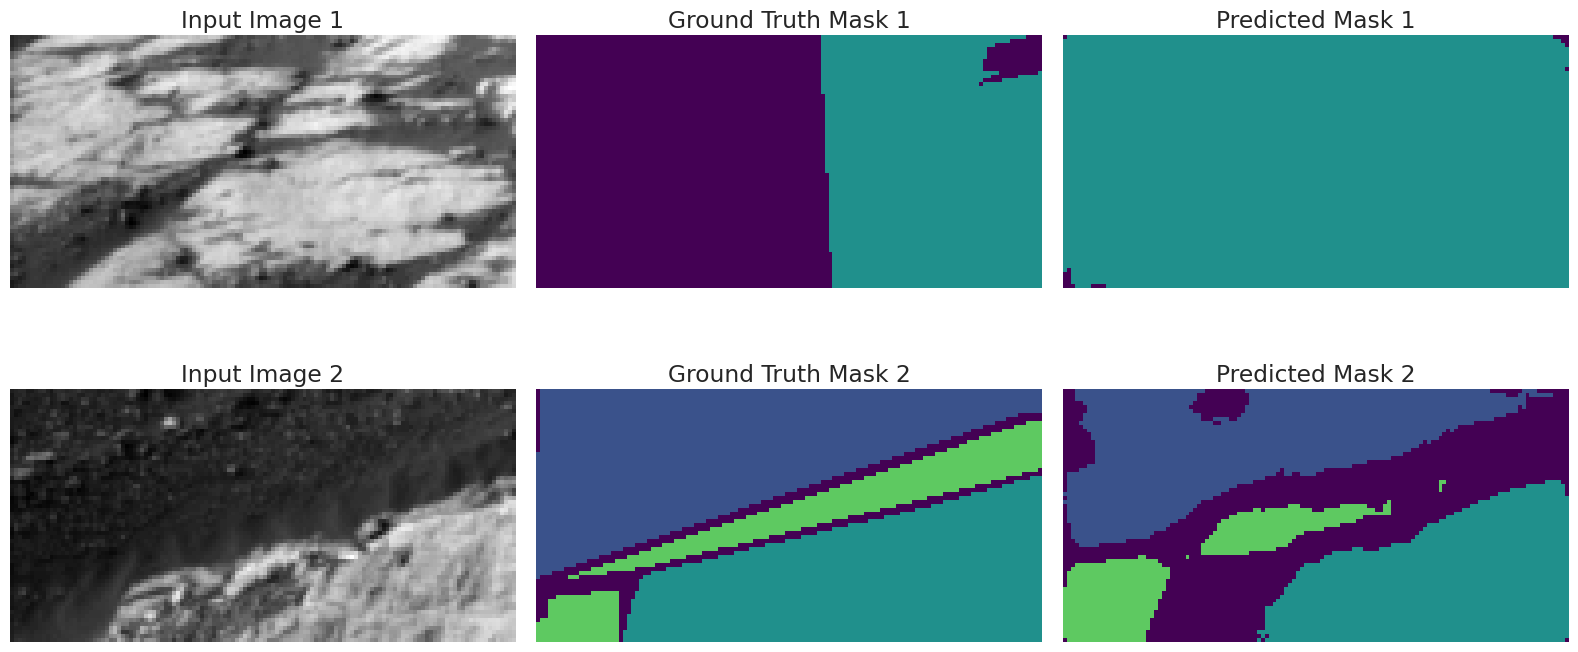

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - accuracy: 0.7833 - loss: 0.0012 - mean_iou: 0.5977 - val_accuracy: 0.7449 - val_loss: 0.0029 - val_mean_iou: 0.5149
Epoch 97/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.7773 - loss: 0.0012 - mean_iou: 0.5990 - val_accuracy: 0.7486 - val_loss: 0.0028 - val_mean_iou: 0.5416
Epoch 98/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.7785 - loss: 0.0012 - mean_iou: 0.6021 - val_accuracy: 0.7533 - val_loss: 0.0027 - val_mean_iou: 0.5330
Epoch 99/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.7781 - loss: 0.0012 - mean_iou: 0.6072 - val_accuracy: 0.7567 - val_loss: 0.0027 - val_mean_iou: 0.5431
Epoch 100/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.7897 - loss: 0.0011 - mean_iou: 0.6254 - val_accuracy: 0.7490 - val_loss: 0.0028 - val_mean_iou: 0.5430
Epoch 101/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7871 - loss: 0.0011 - mean_iou: 0.6100

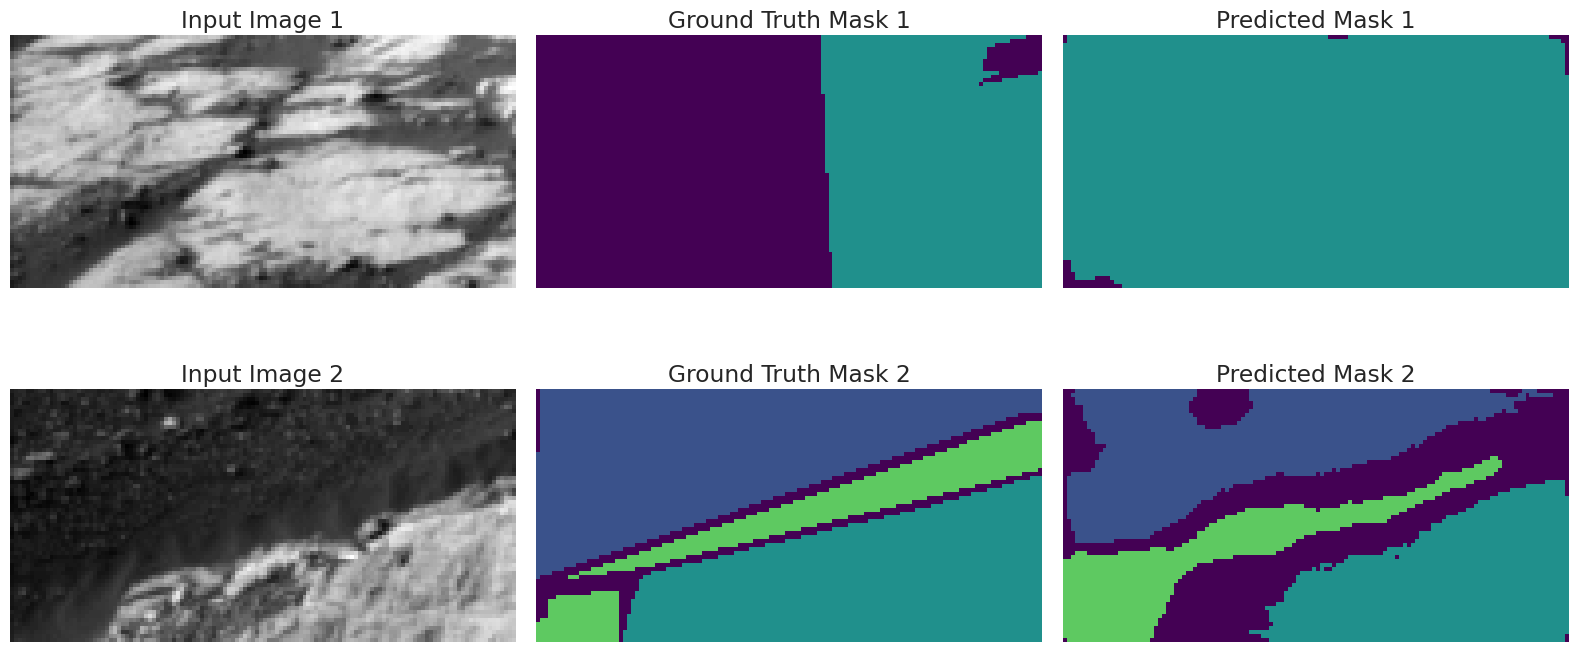

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.7873 - loss: 0.0011 - mean_iou: 0.6104 - val_accuracy: 0.7463 - val_loss: 0.0027 - val_mean_iou: 0.5395
Epoch 102/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.7902 - loss: 0.0011 - mean_iou: 0.6120 - val_accuracy: 0.7567 - val_loss: 0.0028 - val_mean_iou: 0.5583
Epoch 103/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.7877 - loss: 0.0011 - mean_iou: 0.6332 - val_accuracy: 0.7521 - val_loss: 0.0028 - val_mean_iou: 0.5475
Epoch 104/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.7962 - loss: 0.0011 - mean_iou: 0.6326 - val_accuracy: 0.7574 - val_loss: 0.0028 - val_mean_iou: 0.5547
Epoch 105/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.7932 - loss: 0.0011 - mean_iou: 0.6303 - val_accuracy: 0.7561 - val_loss: 0.0028 - val_mean_iou: 0.5479
Epoch 106/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7917 - loss: 0.0011 - mean_iou: 0.6061

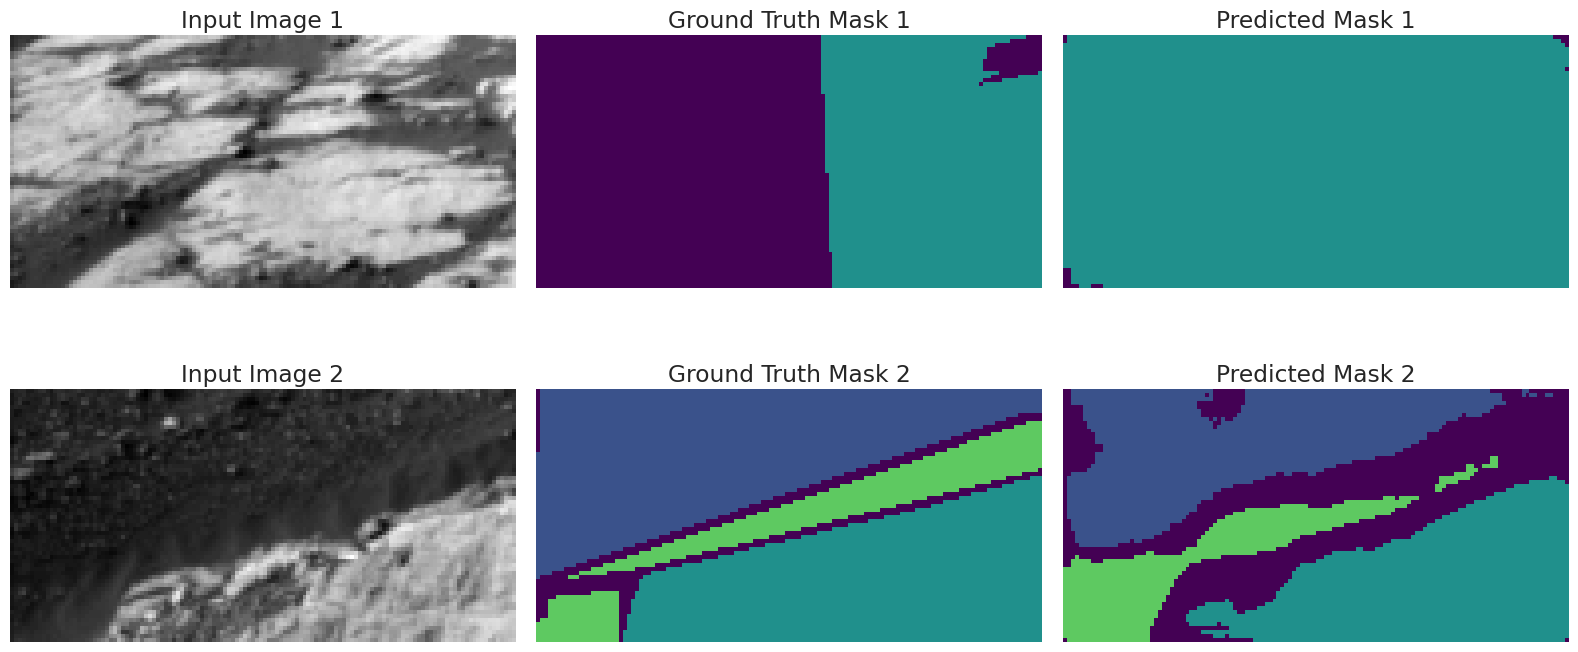

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.7918 - loss: 0.0011 - mean_iou: 0.6062 - val_accuracy: 0.7585 - val_loss: 0.0029 - val_mean_iou: 0.5538
Epoch 107/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.7959 - loss: 0.0010 - mean_iou: 0.6397 - val_accuracy: 0.7592 - val_loss: 0.0028 - val_mean_iou: 0.5557
Epoch 108/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.7934 - loss: 0.0011 - mean_iou: 0.6227 - val_accuracy: 0.7620 - val_loss: 0.0027 - val_mean_iou: 0.5527
Epoch 109/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.7999 - loss: 0.0010 - mean_iou: 0.6412 - val_accuracy: 0.7565 - val_loss: 0.0027 - val_mean_iou: 0.5446
Epoch 110/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.7945 - loss: 0.0011 - mean_iou: 0.6429 - val_accuracy: 0.7644 - val_loss: 0.0028 - val_mean_iou: 0.5615
Epoch 111/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7973 - loss: 0.0011 - mean_iou: 0.6415

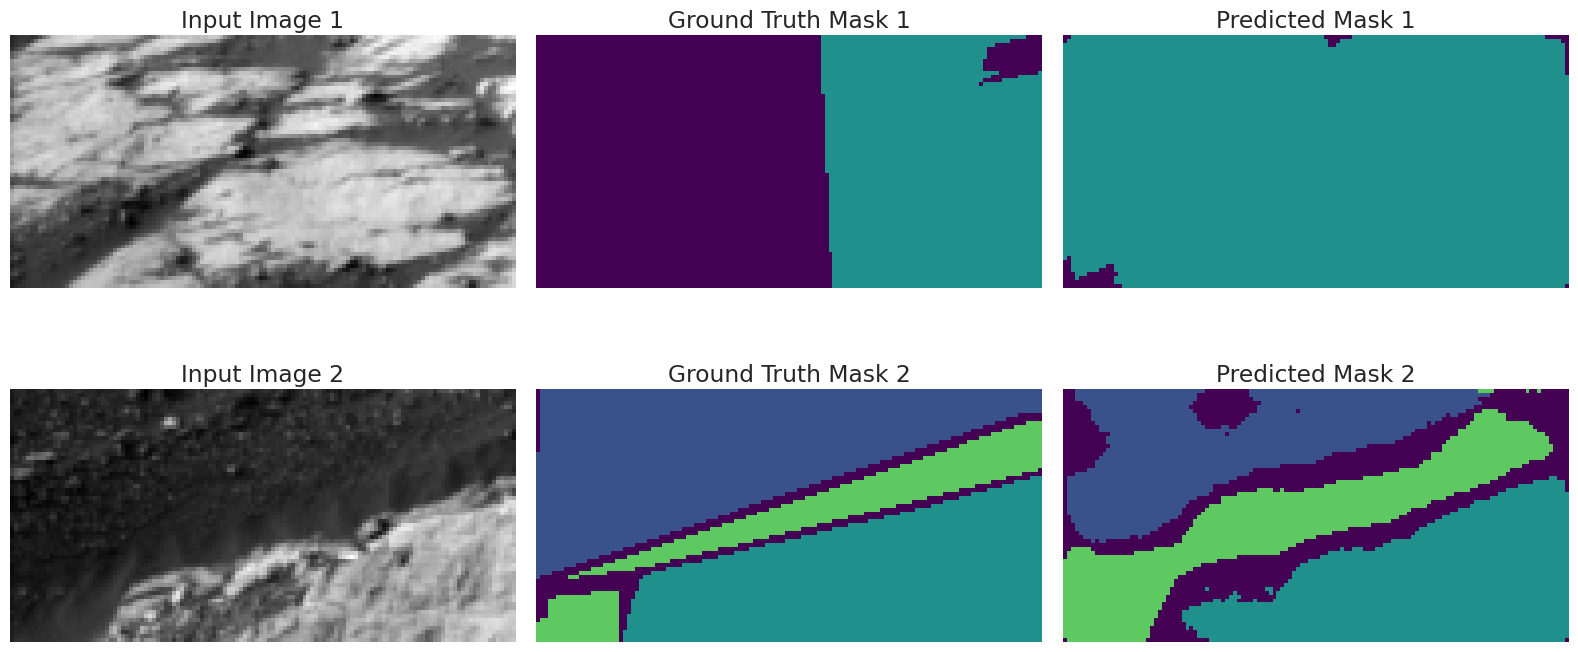

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step - accuracy: 0.7973 - loss: 0.0011 - mean_iou: 0.6411 - val_accuracy: 0.7367 - val_loss: 0.0028 - val_mean_iou: 0.5120
Epoch 112/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.7935 - loss: 0.0011 - mean_iou: 0.6054 - val_accuracy: 0.7547 - val_loss: 0.0029 - val_mean_iou: 0.5273
Epoch 113/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.7666 - loss: 0.0014 - mean_iou: 0.5271 - val_accuracy: 0.7078 - val_loss: 0.0037 - val_mean_iou: 0.4646
Epoch 114/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.7828 - loss: 0.0012 - mean_iou: 0.5518 - val_accuracy: 0.7404 - val_loss: 0.0031 - val_mean_iou: 0.5109
Epoch 115/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.7879 - loss: 0.0011 - mean_iou: 0.5890 - val_accuracy: 0.7592 - val_loss: 0.0029 - val_mean_iou: 0.5417
Epoch 116/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7918 - loss: 0.0011 - mean_iou: 0.6087

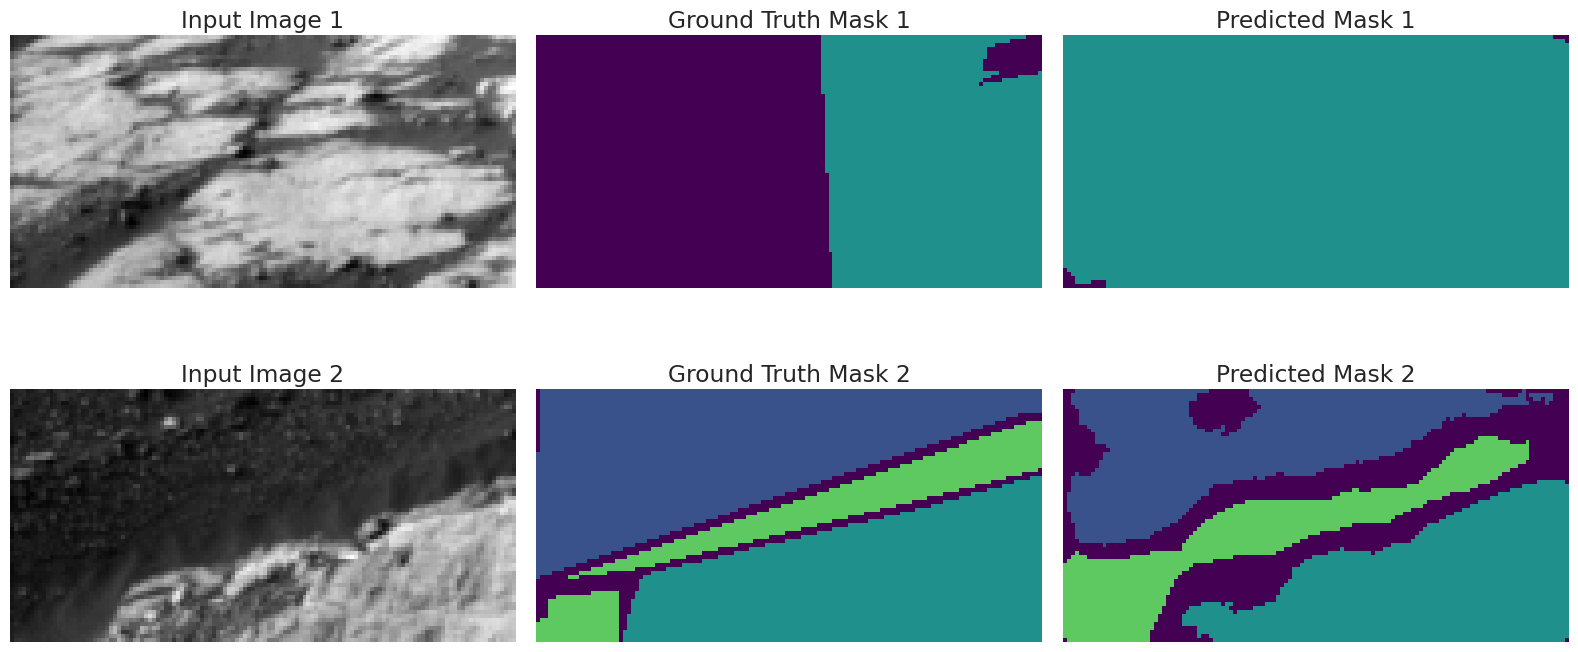

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - accuracy: 0.7921 - loss: 0.0011 - mean_iou: 0.6087 - val_accuracy: 0.7639 - val_loss: 0.0028 - val_mean_iou: 0.5474
Epoch 117/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.8017 - loss: 0.0011 - mean_iou: 0.6047 - val_accuracy: 0.7611 - val_loss: 0.0028 - val_mean_iou: 0.5470
Epoch 118/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.7975 - loss: 0.0011 - mean_iou: 0.6141 - val_accuracy: 0.7604 - val_loss: 0.0028 - val_mean_iou: 0.5510
Epoch 119/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.7950 - loss: 0.0011 - mean_iou: 0.6180 - val_accuracy: 0.7593 - val_loss: 0.0028 - val_mean_iou: 0.5484
Epoch 120/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.8005 - loss: 0.0010 - mean_iou: 0.6369 - val_accuracy: 0.7586 - val_loss: 0.0028 - val_mean_iou: 0.5495
Epoch 121/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7984 - loss: 0.0011 - mean_iou: 0.6386

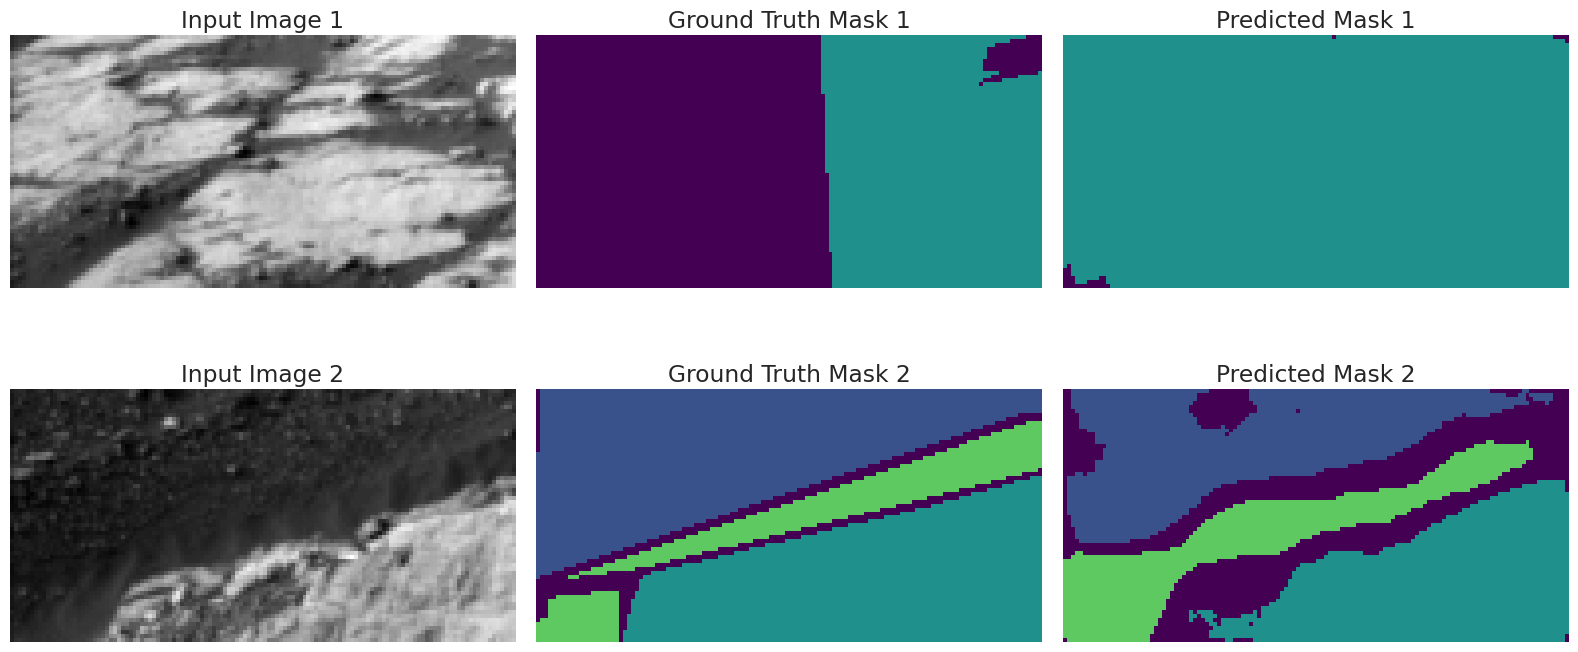

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.7986 - loss: 0.0011 - mean_iou: 0.6386 - val_accuracy: 0.7601 - val_loss: 0.0028 - val_mean_iou: 0.5506
Epoch 122/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.7961 - loss: 0.0011 - mean_iou: 0.6204 - val_accuracy: 0.7618 - val_loss: 0.0028 - val_mean_iou: 0.5539
Epoch 123/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.8021 - loss: 0.0010 - mean_iou: 0.6305 - val_accuracy: 0.7617 - val_loss: 0.0028 - val_mean_iou: 0.5563
Epoch 124/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.7985 - loss: 0.0010 - mean_iou: 0.6217 - val_accuracy: 0.7608 - val_loss: 0.0028 - val_mean_iou: 0.5564
Epoch 125/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.7955 - loss: 0.0010 - mean_iou: 0.6353 - val_accuracy: 0.7616 - val_loss: 0.0028 - val_mean_iou: 0.5585
Epoch 126/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8062 - loss: 0.0010 - mean_iou: 0.6395

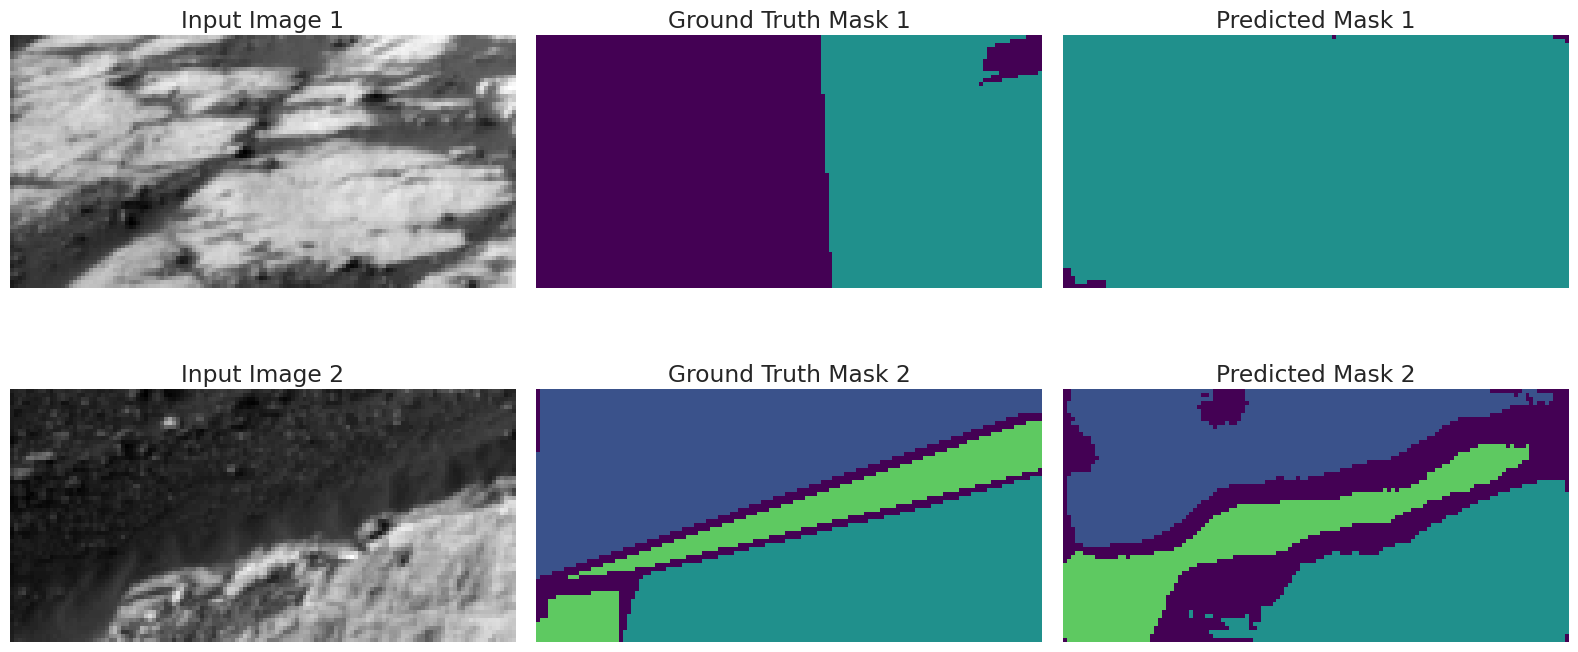

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.8062 - loss: 0.0010 - mean_iou: 0.6396 - val_accuracy: 0.7624 - val_loss: 0.0028 - val_mean_iou: 0.5586
Epoch 127/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.8026 - loss: 0.0010 - mean_iou: 0.6360 - val_accuracy: 0.7623 - val_loss: 0.0028 - val_mean_iou: 0.5588
Epoch 128/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.7992 - loss: 0.0010 - mean_iou: 0.6346 - val_accuracy: 0.7626 - val_loss: 0.0028 - val_mean_iou: 0.5593
Epoch 129/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.8020 - loss: 0.0010 - mean_iou: 0.6454 - val_accuracy: 0.7628 - val_loss: 0.0028 - val_mean_iou: 0.5584
Epoch 130/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.7986 - loss: 0.0011 - mean_iou: 0.6327 - val_accuracy: 0.7629 - val_loss: 0.0028 - val_mean_iou: 0.5586
Epoch 131/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8035 - loss: 0.0010 - mean_iou: 0.6432

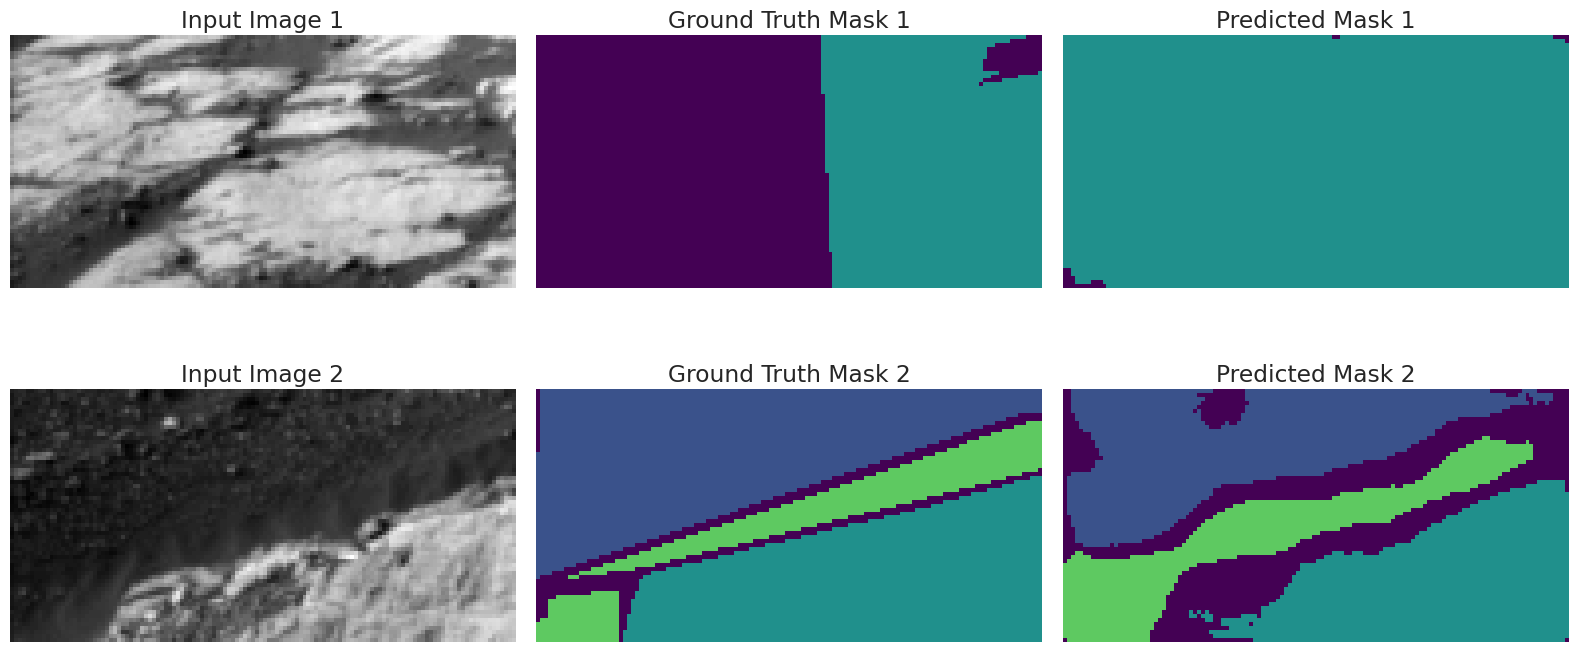

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.8036 - loss: 0.0010 - mean_iou: 0.6432 - val_accuracy: 0.7629 - val_loss: 0.0028 - val_mean_iou: 0.5580
Epoch 132/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.8013 - loss: 0.0010 - mean_iou: 0.6277 - val_accuracy: 0.7629 - val_loss: 0.0028 - val_mean_iou: 0.5583
Epoch 133/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.8038 - loss: 0.0010 - mean_iou: 0.6354 - val_accuracy: 0.7629 - val_loss: 0.0028 - val_mean_iou: 0.5584
Epoch 134/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.7968 - loss: 0.0010 - mean_iou: 0.6384 - val_accuracy: 0.7628 - val_loss: 0.0028 - val_mean_iou: 0.5584
Epoch 135/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.8047 - loss: 0.0010 - mean_iou: 0.6430 - val_accuracy: 0.7629 - val_loss: 0.0028 - val_mean_iou: 0.5582
Epoch 136/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8007 - loss: 0.0010 - mean_iou: 0.6334

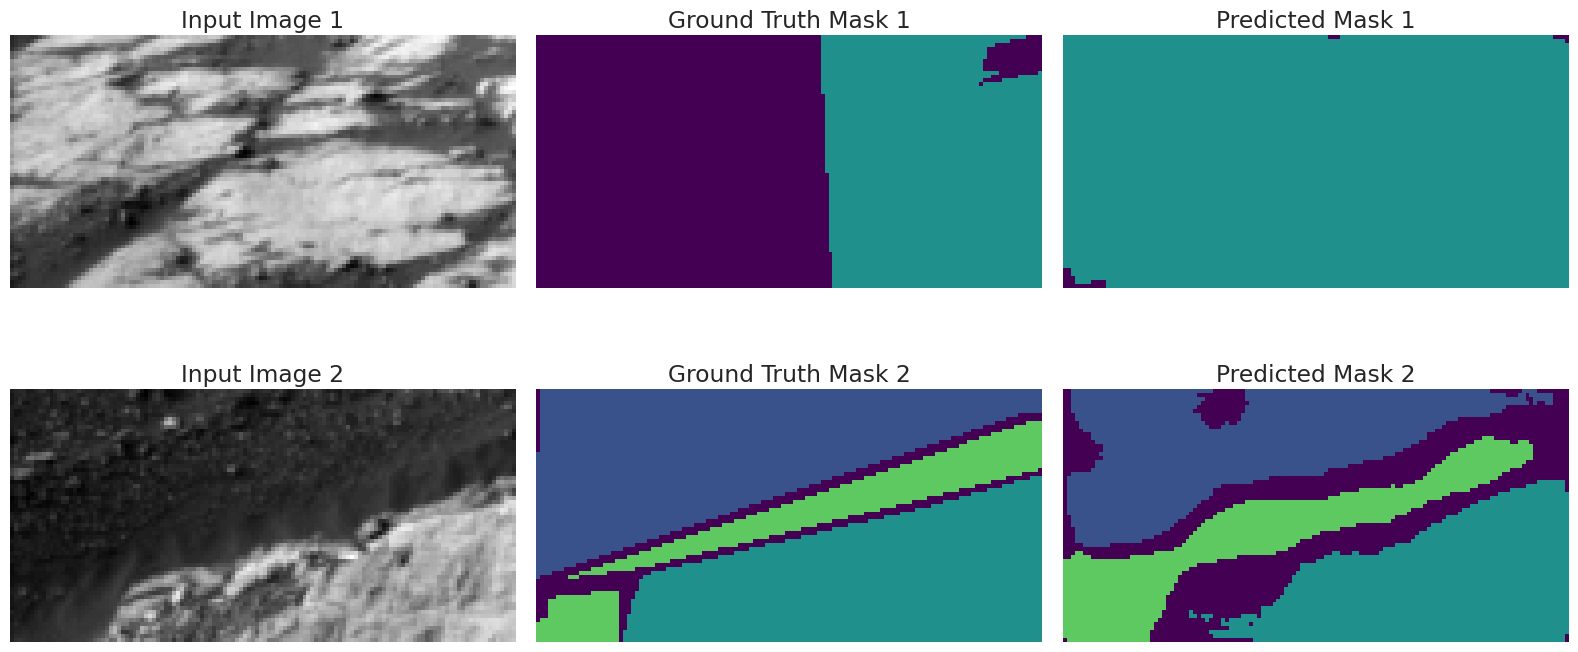

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.8008 - loss: 0.0010 - mean_iou: 0.6336 - val_accuracy: 0.7628 - val_loss: 0.0028 - val_mean_iou: 0.5575
Epoch 137/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.7950 - loss: 0.0011 - mean_iou: 0.6271 - val_accuracy: 0.7626 - val_loss: 0.0028 - val_mean_iou: 0.5572
Epoch 138/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.8039 - loss: 0.0010 - mean_iou: 0.6352 - val_accuracy: 0.7628 - val_loss: 0.0028 - val_mean_iou: 0.5581
Epoch 139/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.8031 - loss: 0.0010 - mean_iou: 0.6356 - val_accuracy: 0.7627 - val_loss: 0.0028 - val_mean_iou: 0.5574
Epoch 140/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.7951 - loss: 0.0010 - mean_iou: 0.6402 - val_accuracy: 0.7627 - val_loss: 0.0028 - val_mean_iou: 0.5576
Final validation Mean Intersection Over Union: 56.15%


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
#model.save(model_filename)

# Delete the model to free up resources
#del model

In [ ]:
weights_filename = 'UNet_weights_' + str(final_val_meanIoU) + '.weights.h5'
model.save_weights(weights_filename)

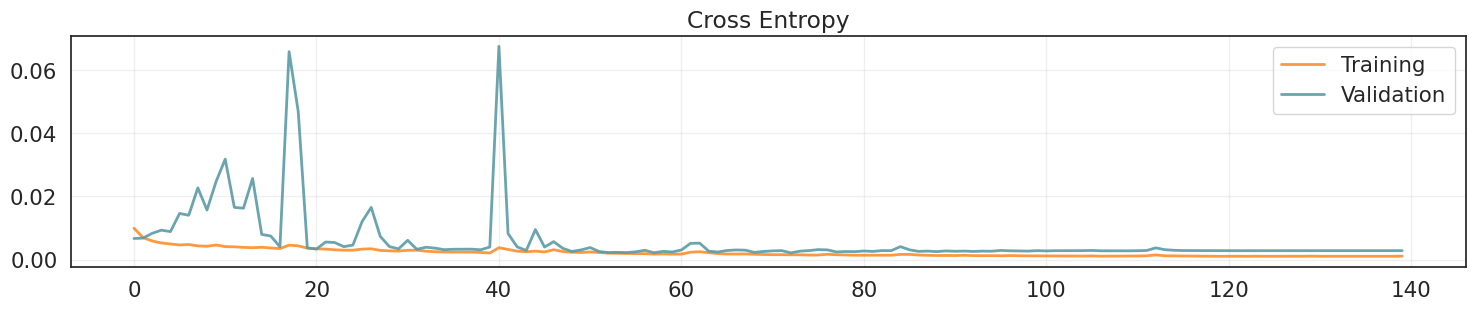

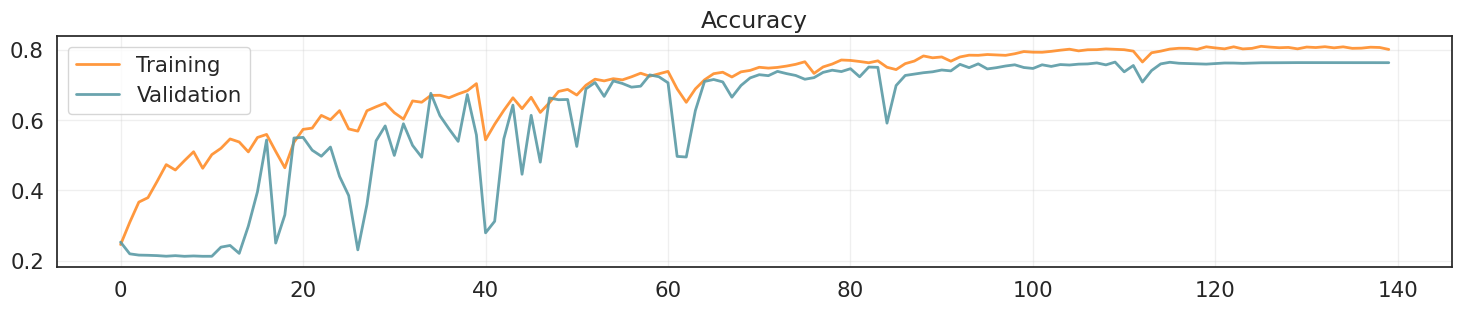

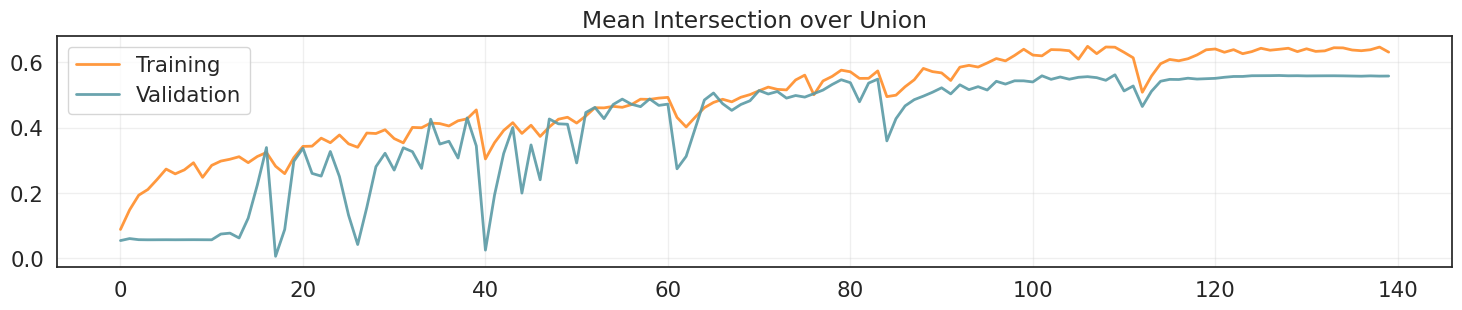

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Above, you can see the progress of the Loss function and of the accuracy and miou for both Training and Validation during the model training

###make inference

We can now use the trained model to see how it performs on a test dataset, never seen by the model before

In [ ]:
# Recreate the model with the original architecture
model = get_unet_model()  # Assuming original architecture

# Load the weights
model.load_weights(weights_filename)

# Compile the model with specified loss, optimizer, and metrics
# Define metrics for each output layer


model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]  # Pass the list of metrics
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_3        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_3[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 2,415,592 (9.21 MB)

 Trainable params: 2,410,728 (9.20 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.7942
Test Mean Intersection over Union: 0.5487


Above, we can see the results from the predictions made on the test dataset

In [ ]:
preds = model.predict(test_dataset, verbose=0) # Convert the list of predictions to a NumPy array
print(f"Predictions shape: {preds.shape}")

Predictions shape: (251, 64, 128, 5)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


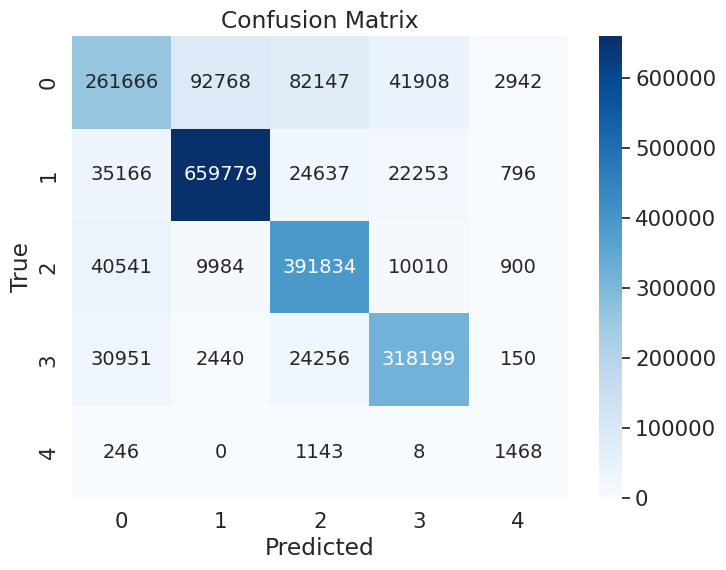

In [ ]:
# Predict on the test set
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Correctly extract and flatten true labels
y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy().flatten())  # Assuming labels are class indices
y_true = np.array(y_true)

# Flatten predictions
y_pred_classes = y_pred_classes.flatten()

# Compute the confusion matrix without excluding any classes.
cm = confusion_matrix(y_true, y_pred_classes, labels=[0, 1, 2, 3, 4])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])  # Use all class labels
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

We use the trained model to predict on the test set and compute the confusion matrix by comparing the predicted and true labels

Below, we process the test dataset, generating predictions using the trained model. Random samples are visualized, displaying the original image, the true mask, and the predicted mask to evaluate the model's performance

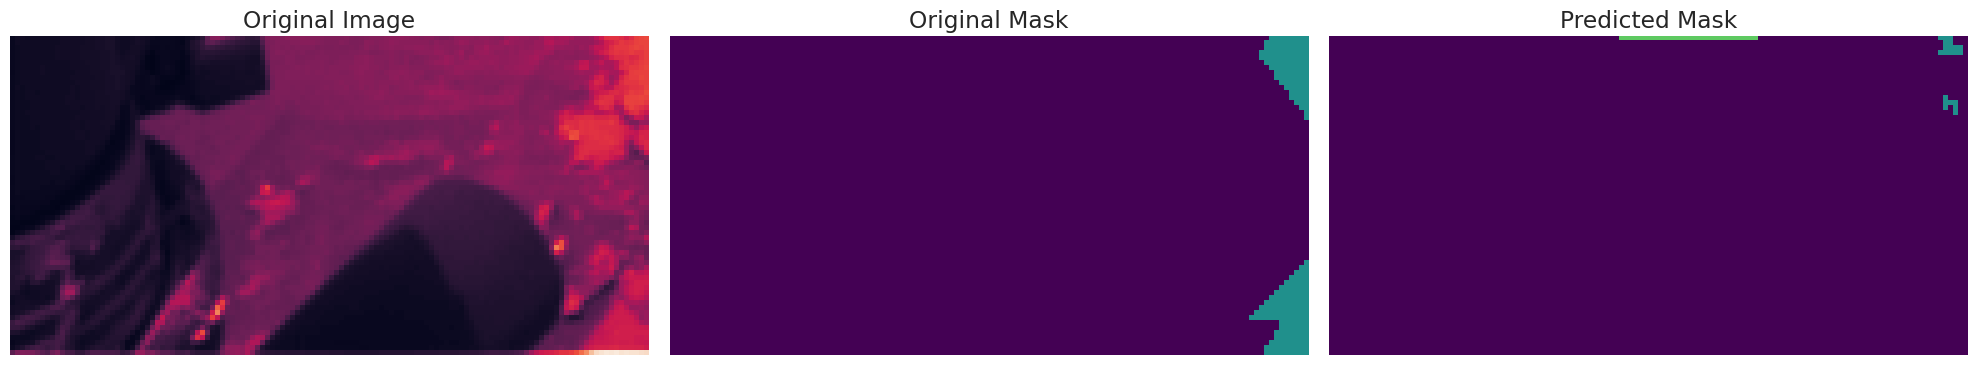

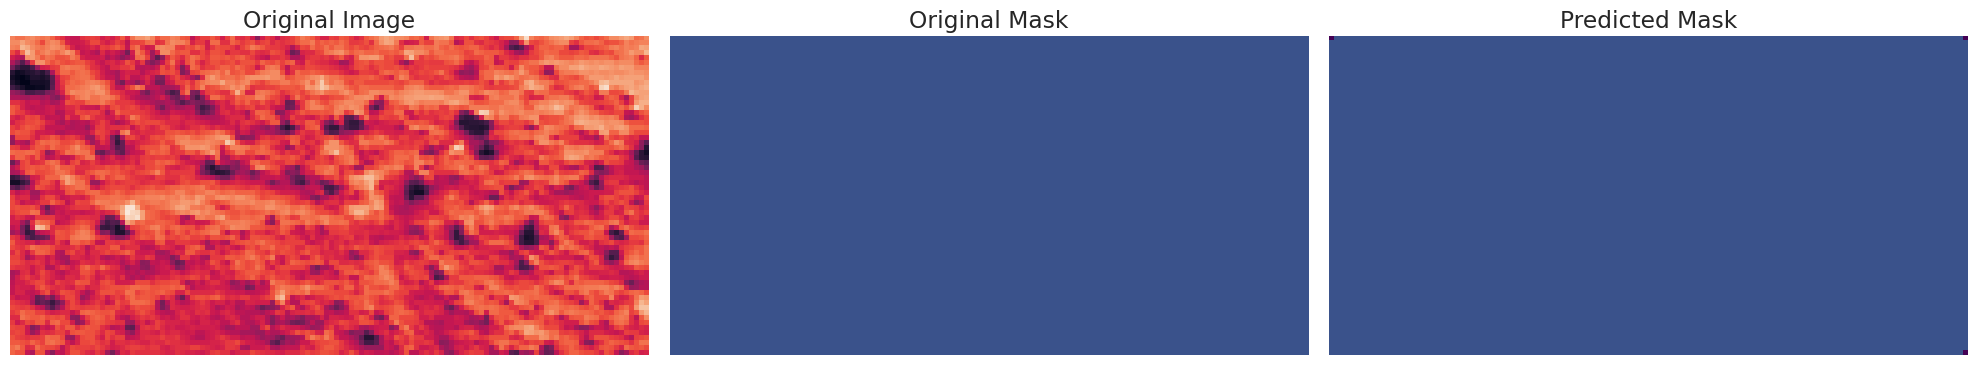

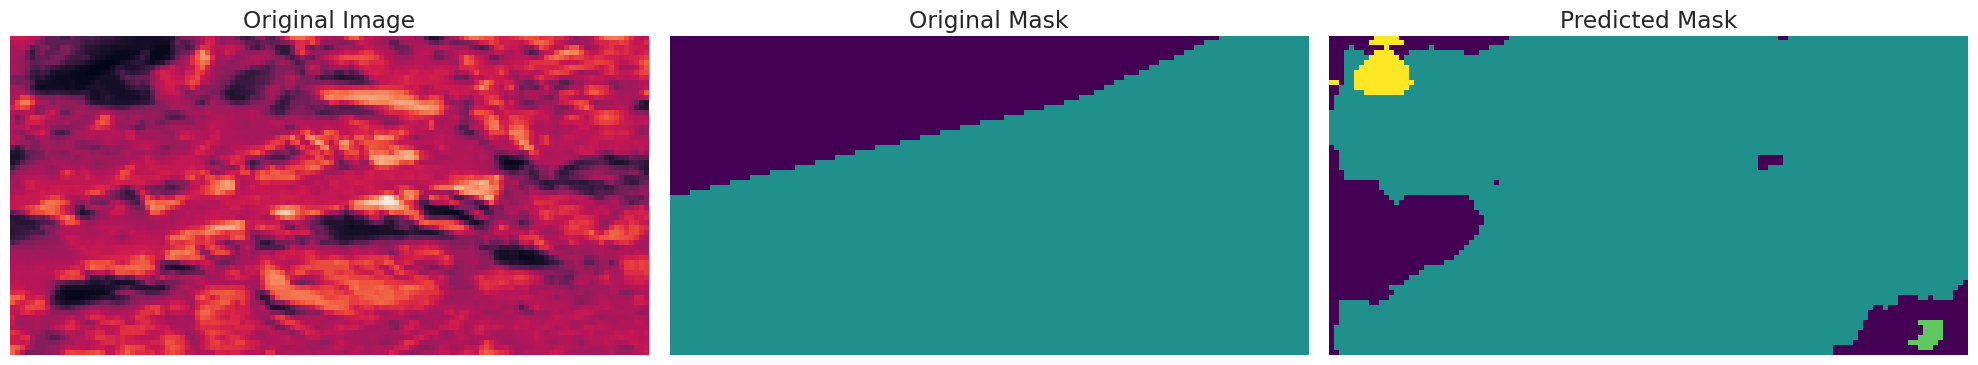

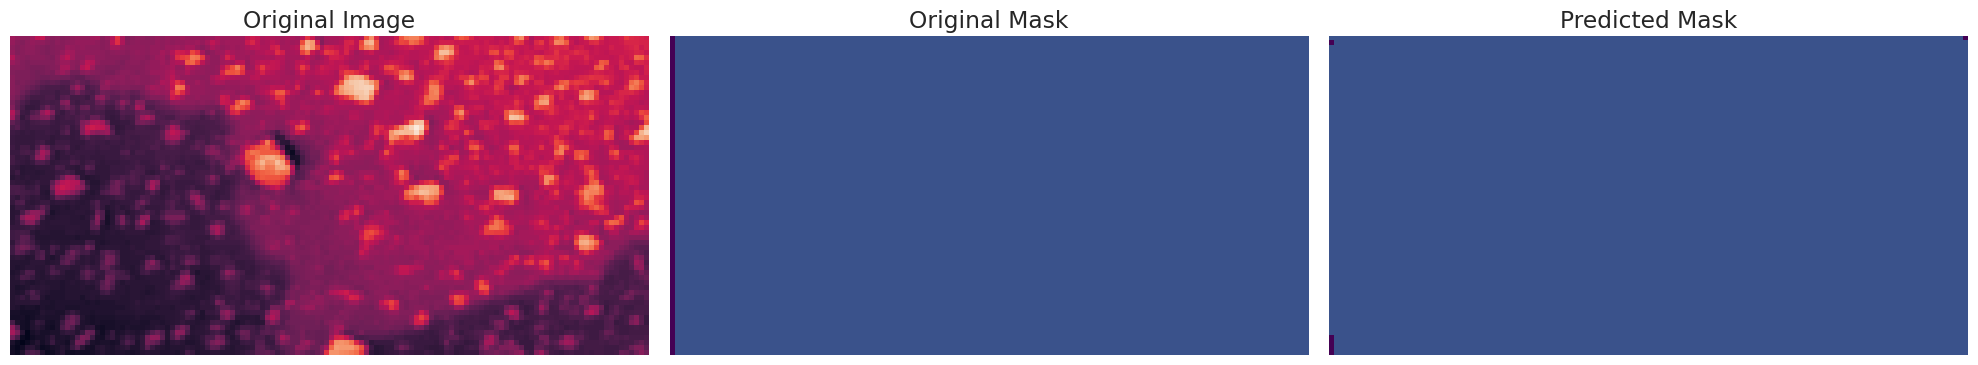

In [ ]:
def plot_triptychs(dataset, model, num_samples=1):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    """
    # Take samples from the dataset
    samples = dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create colormap based on number of classes in labels
        num_classes = 5 #ATTENTION ! Modification did here in place of the following 2 lines. TODO: double check
        # labels_np = labels.numpy()
        # num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0])
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        colored_label = apply_colormap(labels[0], colormap)
        axes[1].imshow(colored_label)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        colored_pred = apply_colormap(pred[0], colormap)
        axes[2].imshow(colored_pred)
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()

# Example usage:
# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=7)

In [ ]:
data = np.load("filtered_mars_for_students.npz")
X_test = data["test_set"]
X_test = X_test / 255.0
X_test = np.expand_dims(X_test, axis=-1)  # Add a channel
print(f"X_test shape: {X_test.shape}")

# Predict in batches to avoid OOM errors
batch_size = 32 # Adjust batch size as needed based on your GPU memory
num_samples = X_test.shape[0]
preds = []

for i in range(0, num_samples, batch_size):
    batch_preds = model.predict(X_test[i:i + batch_size], verbose=0)
    preds.extend(np.argmax(batch_preds, axis=-1))

preds = np.array(preds) # Convert the list of predictions to a NumPy array
print(f"Predictions shape: {preds.shape}")


X_test shape: (10022, 64, 128, 1)
Predictions shape: (10022, 64, 128)


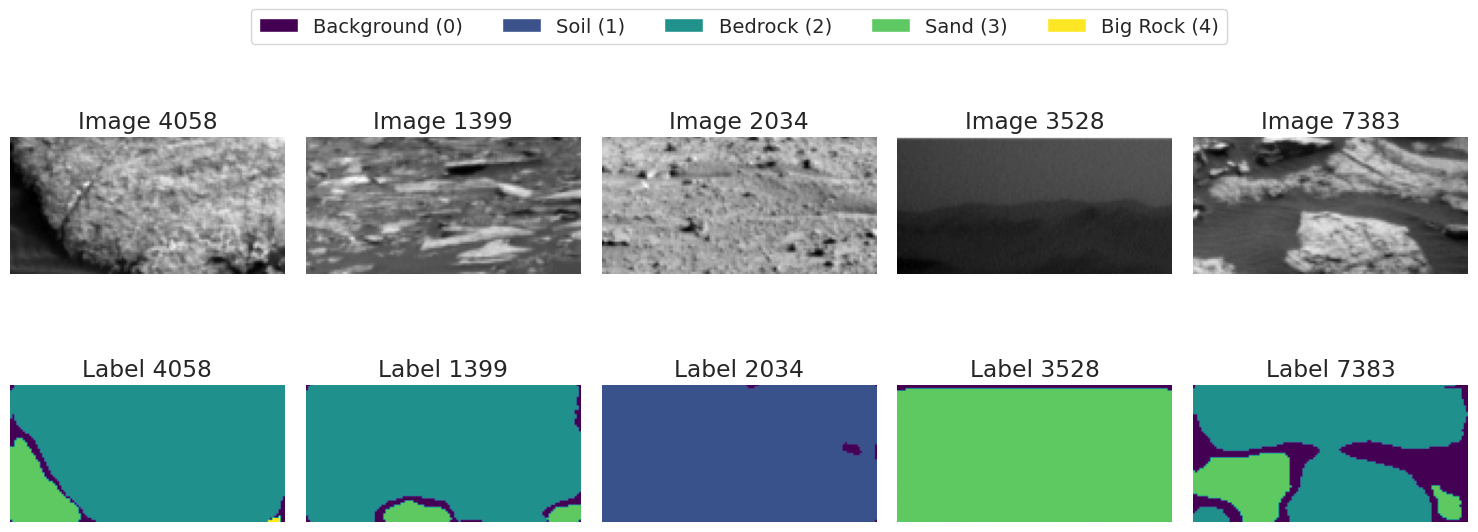

In [ ]:
# Plot 5 random images with labels
plot_random_images_with_labels(X_test, preds, num=5)


Distribuzione delle classi: {0: 19145940, 1: 24166026, 2: 24445236, 3: 14065473, 4: 277549}


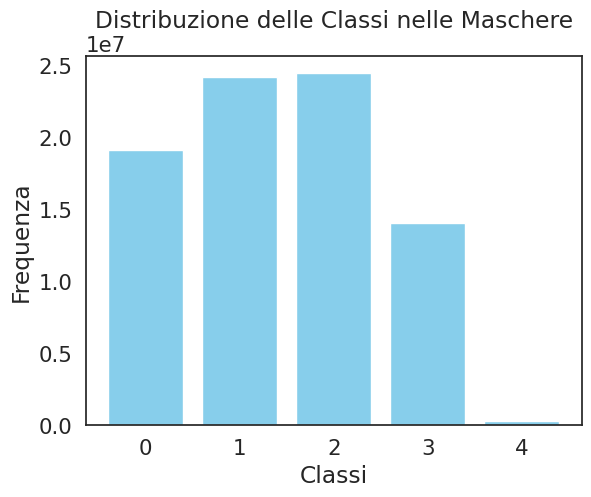

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate class frequencies
unique, counts = np.unique(preds, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar plot
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")


Above, we calculate and visualize the distribution of predicted classes, providing insights into class frequencies, and print the number of unique predicted classes to assess the model's output diversity

##🗂️preparing the submission

In [ ]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved to: {submission_filename}")
# from google.colab import files
# files.download(submission_filename)

Submission file saved to: submission_UNet_56.15.csv
